This script has 3 functions in 3 parts:
1. It takes in raw data, normalizes it and stores it in a way useable by sasmodels
2. It analyzes the peaks by fitting gaussians using SASmodels as an engine
3. It visualizes the data and calculates parameters such as crystal lattice parameters

In [1]:
import copy
import datetime
import sys
# put the path here to the sasmodels source code
sys.path.append(r'C:/Users/lorte/Documents/SASmodels/sasview/src')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bumps

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas
import os
import math

from numpy import exp, linspace, random
from scipy.optimize import curve_fit

# put the path here to parent folder which should include this script, the data, and sample information csv's (3)
# normalized data as well as fit results will be saved in this parent folder as well
path = r"/Users/lorte/Google Drive/Python_Scripts/waxs"

# append here the name of the raw data file in .dat format. 
#Again place this data  folder within the parent folder above
data_path = path + '/desmeared_waxs_data'

# Section 1: Reading and Processing Raw Data

In [2]:
# read data function
def waxs_read(waxs_data):
    file = open(waxs_data, 'r')
    
    lines = file.readlines()[5:]
    lines = [line[:-2].split() for line in lines if '<' not in line]
    
    data = np.array(lines).astype(float)
    data[:,0] = data[:,0]
    #data[:,0] = data[:,0]/10
    
    return data

In [3]:
# amorphous polystyrene peak analyzer function
def peak_analysis(data, min_q=None, max_q=None):
    
    """
    Finds the peak location and scattering intensity for WAXS data.
    
    Use the min_q and max_q parameters to define the fitting region.
    The peak of interest should be the tallest point in that range.
    
    Parameters
    ----------
    data : ndarray
        UV-Vis data to be fit.
        First index along axis=1 wavelength in nm.
        Second index along axis=1 absorbance intensity.
    min_nm : int, float
        Minimum scattering vector, q, to fit the data.
        Function assumes peak is highest point in the data.
        Defult: None
    max_nm : int, float
        Maximum scattering vector, q, to fit the data.
        Function assumes peak is highest point in the data.
        Default: None
    
    Returns
    -------
    peak_q : float
        Location of the peak in nm.
    peak_int : float
        Scattering intensity at the peak location.
    p : numpy.poly1d
        2nd-degree polynomial fit of the peak position.
        
    """
    
    mask = np.where((data[:,0] > min_q) & (data[:,0] < max_q))
    fit_data = data[mask]
    
    fit = np.polyfit(fit_data[:,0], fit_data[:,1], 2)
    p = np.poly1d(fit)
    p1 = p.deriv()
    
    peak_q = p1.r[0]
    peak_int = p(peak_q)
    
    return (peak_q, peak_int, p)

In [4]:
#load data into arrays
waxs_files = [data_path + "/" + x for x in os.listdir(data_path) if x[0] != '.']
waxs_data = {}
for file in waxs_files:
    filename = file.split('/')[-1].split('_')
    counter = 0
    counter_2 = 0
    while counter_2 == 0:
        if filename[counter].isnumeric():
            counter_2 = 1
        else:
            counter = counter + 1
    key = int(filename[counter])
    waxs_data[key] = waxs_read(file)

In [5]:
# fitting the polystyrene peak at approx. 1.35 1/Angstroms
# will be used to normalize all the data in their respective batches
# also applying data mask
for key in waxs_data:
    mask = np.where((waxs_data[key][:,0] > 0) & (waxs_data[key][:,0] < 3))
    waxs_data[key] = waxs_data[key][mask]
    waxs_data[key][:,1] = waxs_data[key][:,1]-min(waxs_data[key][:,1])
    peak = peak_analysis(waxs_data[key], 1.2, 1.5)[1]
    waxs_data[key][:,1] = waxs_data[key][:,1]*(peak**-1)

In [6]:
#makes new data files of normalized data and dictionary of data keys and their filepaths
formatted_data_path = data_path +'_sasview_format'
if 'desmeared_waxs_data_sasview_format' in os.listdir(path):
    print('formatted data path already exists')
    waxs_data_paths = {}
    for key in waxs_data:
        file = formatted_data_path + "/" + "CMW" + str(key) + ".ABS"
        waxs_data_paths[key] = file
else:
    os.mkdir(formatted_data_path)
    waxs_data_paths = {}
    for key in waxs_data:
        file = formatted_data_path + "/" + "CMW" + str(key) + ".ABS"
        a_file = open(file, "w")
        np.savetxt(a_file, waxs_data[key], header='<X> <Y> <dY>')
        a_file.close()
        waxs_data_paths[key] = file

formatted data path already exists


In [7]:
"""
Loading in the data and meta-data, do not edit unless necessary for os differences.
"""
# sample meta-data
info_path = path + "/Sample_Info.csv"
corrected_path = path + "/Corrected_wtPercents.csv"
sample_info = pd.read_csv(info_path)
corrected_info = pd.read_csv(corrected_path)
names = {}
cps = {}
matrix = {}
solvent_names = {}
target = {}  # target weight fraction of conjugated polymer
actual = {} # corrected weight fraction of conjugated polymer from UV-vis data

for index, row in sample_info.iterrows():
    sam_no = int(row['Sample'])
    names[sam_no] = row['Name']
    cps[sam_no] = row['Conjugated Polymer']
    matrix[sam_no] = row['Commodity Polymer']
    solvent_names[sam_no] = row['Solvent']
    # change this if target fraction is already in wt percent, rather than wt fraction
    target[sam_no] = float(row['Target Fraction'])*100
for index, row in corrected_info.iterrows():
    sam_no = int(row['Sample'])
    # change this if actual fraction is already in wt percent rather than wt fraction
    actual[sam_no] = float(row['average actual wt pct'])

In [8]:
# creates folder in parent folder in which to save fits
fit_path = data_path +'_fits'
if 'desmeared_waxs_data_fits' in os.listdir(path):
    print('fit folder already exist')
else:
    os.mkdir(fit_path)

# this function reads and writes fits
def fit_reader(sample, new_fit = 0):
    if new_fit == 0:
        searched = 'CMW' + str(sample) +'.txt'
        fit_dict = {}
        for fit_path_name in os.listdir(fit_path):
            if searched in fit_path_name:
                file = open(fit_path + "/" + fit_path_name, 'r')
                the_lines = file.readlines()
                for each in the_lines:
                    split_line = each.split(" ")
                    fit_dict[split_line[0]] = float(split_line[1])
        if bool(fit_dict) is False:
            print('could not find fit for '+str(sample))
        return fit_dict
    else:
        a_file = open(fit_path + "/" + "CMW" + str(sample) + ".txt", "w")
        for x in new_fit:
            param_line = x + " " + str(new_fit[x])
            a_file.write(param_line)
            a_file.write("\n")
        a_file.close()

fit folder already exist


In [9]:
# ths function takes in a list of sample keys, and a fit, if you want, and plots it, fit including, if you want. 
def fit_plotter(key_list, fit):
    plt.figure(figsize=(6,6))
    for key in key_list:
        data = load_data(waxs_data_paths[key])

        def gaussian(x, height, center, width, offset):
            return height*np.exp(-(x - center)**2/(2*width**2)) + offset

        def many_gaussians(x, h1, s1, w1, h2, s2, w2, h3, s3, w3, h4, s4, w4, h5, s5, w5, h6, s6, w6, offset):
            return (gaussian(x, h1, s1, w1, offset=0) +
                gaussian(x, h2, s2, w2, offset=0) +
                gaussian(x, h3, s3, w3, offset=0) +
                gaussian(x, h4, s4, w4, offset=0) +
                gaussian(x, h5, s5, w5, offset=0) +
                gaussian(x, h6, s6, w6, offset=0) + offset)

        thefit = dict(fit)
        background = thefit['background']
        fit_list = []
        thefit.pop('scale')
        thefit.pop('background')
        for parameter in thefit:
            fit_list.append(thefit[parameter])
        optim = np.append(fit_list, background)

        plt.plot(data.x, data.y, lw=1, c='g', label= 'data')
        plt.plot(data.x, many_gaussians(data.x, *optim), lw=2, c='b', label='fit')
        plt.plot(data.x, gaussian(data.x, *optim[0:3], optim[18]), lw=1, linestyle='dashed', label='amorphous peak')
        plt.plot(data.x, gaussian(data.x, *optim[3:6], optim[18]), lw=1, linestyle='dashed', label='polymerization peak')
        plt.plot(data.x, gaussian(data.x, *optim[6:9], optim[18]), lw=1, linestyle='dashed', label='residual peak')
        plt.plot(data.x, gaussian(data.x, *optim[9:12], optim[18]), lw=1, linestyle='dashed', label='background peak')
        plt.plot(data.x, gaussian(data.x, *optim[12:15], optim[18]), lw=1, linestyle='dashed', label='lamellar peak')
        plt.plot(data.x, gaussian(data.x, *optim[15:18], optim[18]), lw=1, linestyle='dashed', label='pi-stacking peak')

        plt.title(str(target[key]) +'% ' + cps[key] + ' in PS-D8 from ' +solvent_names[key], fontsize =16)
        plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
        plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

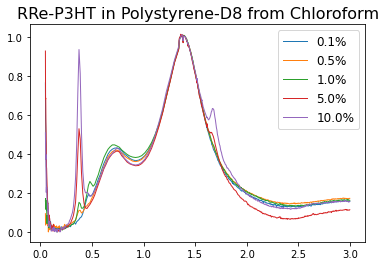

In [11]:
samplelist = [1,2,3,4,5]
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= (str(target[sample])+ '%'))
    plt.title(cps[sample] + ' in ' + matrix[sample]+ ' from ' +solvent_names[sample], fontsize =16)
    plt.legend(fontsize=12)       

# Section 2: Peak Fitting

In [12]:
# this is the initial params needed to guess the gaussian peaks at the beginning
initial_params = {
    'scale' : 1,
    'background' : 0,
    'A_scale' : 0.9,
    'A_peak_pos' : 1.34,
    'A_sigma' : 0.2,
    'B_scale' : 0.5,
    'B_peak_pos' : 0.74,
    'B_sigma' : 0.24,
    'C_scale' : 0.22,
    'C_peak_pos' : 2,
    'C_sigma' : 0.26,
    'D_scale' : 0.0,
    'D_peak_pos' : 0.05,
    'D_sigma' : 0.12,
    'E_scale' : 0.1,
    'E_peak_pos' : 0.35,
    'E_sigma' : 0.03,
    'F_scale' : 0.1,
    'F_peak_pos' : 1.65,
    'F_sigma' : 0.01,
}

In [13]:
# this is the core fitting function
# Input: sample #, # of gaussians to fit, and fitting q limits, 
# Returns: fit parameters dictionary and chisquared
def fitter(sample, use_fit = 0, lamellar =False, pi_stacking = False, qmin = 0, qmax = 10, alternate = 0.35, fitmethod = 'lm'):
    model_name = 'gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak'
    data = load_data(waxs_data_paths[sample])
    data.dx = data.dx-data.dx # removing any smeared contributions for now if they exist
    data.qmin = qmin 
    data.qmax = qmax

    # starting fit parameters
    if use_fit == 0:
        params = dict(initial_params)
        if lamellar is False:
            params['E_scale']= 0
            params['E_peak_pos'] = 0
            params['E_sigma'] =1
        else:
            params['E_peak_pos'] = alternate
        if pi_stacking is False:
            params['F_scale']= 0
            params['F_peak_pos'] =0
            params['F_sigma'] =1
    else:
        params = use_fit

    # setting up the model
    kernel=load_model(model_name)
    model=Model(kernel, **params)

    #set the ranges
    model.A_scale.range(0.5,1.2)
    model.A_peak_pos.range(1,2)
    model.A_sigma.range(0.001,1)
    model.B_scale.range(0.01,1)
    model.B_peak_pos.range(0,1)
    model.B_sigma.range(0.001,1)
    model.C_scale.range(0.001,0.5)
    model.C_peak_pos.range(1.5,2.5)
    model.C_sigma.range(0.001,0.4)
    #model.D_scale.range(0,0.2)
    #model.D_peak_pos.range(0,0.05)
    #model.D_sigma.range(0.001,1)
    if lamellar is True:
        model.E_scale.range(0,2)
        model.E_peak_pos.range(0.2,0.4)
        model.E_sigma.range(0,0.03)
    if pi_stacking is True:
        model.F_scale.range(0,2)
        model.F_peak_pos.range(1.5,1.7)
        model.F_sigma.range(0,0.04)

    #running the model
    experiment=Experiment(data=data,model=model)
    problem=bumps.names.FitProblem(experiment)
    if fitmethod == 'lm':
        result=bumps.fitters.fit(problem,method='lm', verbose= True)
    elif fitmethod == 'dream':
        result=bumps.fitters.fit(problem,method='dream', verbose= True)
    else:
        print('Select between lm and dream fit')
    
    return problem.fitness.model.state(), problem.chisq()

The following cell takes in a number of cycles and fits according to LV algorithm

In [22]:
listr = list(waxs_data.keys())
listr.sort()
# here, a sample number list is taken for fitting
samplelist = listr
final_fits = {}
# here, you change the fitting q limits
qmin = 0.01
qmax = 2
# this feeds the parameters through twice, and cycles through different # of gaussians
# the best fit is determined by comparing chi squared results and saved in final_fits
for num in samplelist:
    print('fitting sample ' + str(num))
    chisq = []
    fits = {}
    options = [[False, False, 0.35],[True, False, 0.35], [True, True, 0.35],[False, False, 0.25],[True, False, 0.25], [True, True, 0.25]]
    for i in range(len(options)):
        theresult, thechisq = fitter(num, use_fit = 0, lamellar = options[i][0], pi_stacking = options[i][1], qmin = qmin, qmax = qmax, alternate = options[i][2])
        theresult, thechisq = fitter(num, use_fit = theresult, lamellar = options[i][0], pi_stacking = options[i][1], qmin = qmin, qmax = qmax, alternate = options[i][2])
        chisq.append(thechisq)
        fits[i] = theresult
    for i in range(len(chisq)):
        if chisq[i] == min(chisq):
            final_fits[num] = fits[i]
# lastly, the fit is saved in the parent folder as txt
    fit_reader(num, new_fit = final_fits[num])

final chisq 1045.069(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37961(10)     1.3796051(32)  
                                 A_scale 0.94151(28)     0.9415113(86)  
                                 A_sigma 0.19414(11)     0.1941436(33)  
                              B_peak_pos 0.75944(12)     0.7594424(37)  
                                 B_scale 0.419572(97)    0.4195721(30)  
                                 B_sigma 0.22030(13)     0.2203002(40)  
                              C_peak_pos 1.87528(40)     1.875284(12)   
                                 C_scale 0.21391(16)     0.2139131(50)  
                                 C_sigma 0.20789(59)     0.207893(18)   
final chisq 1045.068(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37958(10)     1.3795779(32)  
                                 A_scale 0.94143(28)     0.94143

final chisq 1177.115(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38332(10)     1.3833168(30)  
                                 A_scale 0.94268(28)     0.9426837(81)  
                                 A_sigma 0.19376(11)     0.1937589(31)  
                              B_peak_pos 0.76132(12)     0.7613203(36)  
                                 B_scale 0.416973(97)    0.4169735(28)  
                                 B_sigma 0.22689(14)     0.2268933(40)  
                              C_peak_pos 1.88131(40)     1.881310(12)   
                                 C_scale 0.20858(16)     0.2085758(46)  
                                 C_sigma 0.20793(62)     0.207926(18)   
                              E_peak_pos 0.20018(64)     0.200184(19)   
                                 E_scale 0.03276(51)     0.032755(15)   
                                 E_sigma 0.029999928782(54) 0.0299999287822(16)
final chisq 11

final chisq 9860.766(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386723(78)    1.38672285(79) 
                                 A_scale 0.93079(12)     0.9307933(12)  
                                 A_sigma 0.20387(12)     0.2038716(12)  
                              B_peak_pos 0.75785(14)     0.7578493(14)  
                                 B_scale 0.40560(10)     0.4056000(10)  
                                 B_sigma 0.22123(17)     0.2212328(17)  
                              C_peak_pos 1.81146(32)     1.8114580(32)  
                                 C_scale 0.18822(35)     0.1882191(35)  
                                 C_sigma 0.14201(23)     0.1420144(23)  
                              E_peak_pos 0.35297(61)     0.3529693(62)  
                                 E_scale 0.02336(43)     0.0233567(43)  
                                 E_sigma 0.03000(66)     0.0300000(67)  
                     

final chisq 1201.752(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37339(21)     1.3733902(60)  
                                 A_scale 0.8996(18)      0.899571(52)   
                                 A_sigma 0.19745(17)     0.1974451(48)  
                              B_peak_pos 0.74259(12)     0.7425893(34)  
                                 B_scale 0.439302(98)    0.4393015(28)  
                                 B_sigma 0.22817(15)     0.2281711(44)  
                              C_peak_pos 1.9186(10)      1.918630(30)   
                                 C_scale 0.21478(20)     0.2147774(57)  
                                 C_sigma 0.3074(34)      0.307442(97)   
                              E_peak_pos 0.366(60)       0.3662(17)     
                                 E_scale 0.24(40)e-3     238(12)e-6     
                                 E_sigma 0.029999967318(55) 0.0299999673182(16)
final chisq 12

final chisq 1330.857(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37281(21)     1.3728124(57)  
                                 A_scale 0.8974(18)      0.897355(50)   
                                 A_sigma 0.19850(16)     0.1984983(45)  
                              B_peak_pos 0.74096(12)     0.7409648(32)  
                                 B_scale 0.440545(97)    0.4405450(27)  
                                 B_sigma 0.22807(14)     0.2280720(38)  
                              C_peak_pos 1.92746(96)     1.927457(26)   
                                 C_scale 0.21391(18)     0.2139074(50)  
                                 C_sigma 0.3122(36)      0.312167(99)   
                              E_peak_pos 0.24(15)        0.2385(40)     
                                 E_scale 0.12(43)e-3     125(12)e-6     
                                 E_sigma 0.029999969423(59) 0.0299999694228(16)
              

final chisq 4443.801(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.369371(64)    1.36937059(96) 
                                 A_scale 0.7483(54)      0.748266(80)   
                                 A_sigma 0.17344(32)     0.1734393(47)  
                              B_peak_pos 0.76215(68)     0.762152(10)   
                                 B_scale 0.37728(50)     0.3772810(74)  
                                 B_sigma 0.26557(38)     0.2655742(58)  
                              C_peak_pos 1.6474(51)      1.647411(76)   
                                 C_scale 0.2796(25)      0.279613(38)   
                                 C_sigma 0.3028(25)      0.302789(37)   
final chisq 4443.801(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.369371(64)    1.36937059(96) 
                                 A_scale 0.7483(54)      0.74826

final chisq 2283.096(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36703(40)     1.3670288(83)  
                                 A_scale 0.9032(24)      0.903208(51)   
                                 A_sigma 0.20645(22)     0.2064512(46)  
                              B_peak_pos 0.73767(12)     0.7376717(25)  
                                 B_scale 0.40245(11)     0.4024452(23)  
                                 B_sigma 0.19500(14)     0.1950038(28)  
                              C_peak_pos 1.8331(26)      1.833138(53)   
                                 C_scale 0.23114(86)     0.231135(18)   
                                 C_sigma 0.2697(25)      0.269741(51)   
                              E_peak_pos 0.373925(24)    0.37392550(50) 
                                 E_scale 0.74373(43)     0.7437309(90)  
                                 E_sigma 0.029999847317(56) 0.0299998473167(12)
final chisq 17

final chisq 15715.097(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36966(28)     1.3696570(22)  
                                 A_scale 0.8914(35)      0.891357(28)   
                                 A_sigma 0.20017(23)     0.2001694(18)  
                              B_peak_pos 0.70701(12)     0.70701182(96) 
                                 B_scale 0.40745(11)     0.40745258(88) 
                                 B_sigma 0.24250(17)     0.2424987(13)  
                              C_peak_pos 1.8899(25)      1.889860(20)   
                                 C_scale 0.22689(42)     0.2268883(34)  
                                 C_sigma 0.3265(54)      0.326532(43)   
                              E_peak_pos 0.250(11)       0.250184(90)   
                                 E_scale 0.00108(48)     0.0010782(38)  
                                 E_sigma 0.029999907135(63) 0.02999990713490(50)
            

final chisq 1179.561(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37899(10)     1.3789861(30)  
                                 A_scale 0.94144(30)     0.9414424(88)  
                                 A_sigma 0.19185(10)     0.1918473(29)  
                              B_peak_pos 0.76188(12)     0.7618807(35)  
                                 B_scale 0.413724(98)    0.4137240(28)  
                                 B_sigma 0.22125(13)     0.2212481(38)  
                              C_peak_pos 1.87208(44)     1.872080(13)   
                                 C_scale 0.20675(16)     0.2067462(46)  
                                 C_sigma 0.21397(59)     0.213969(17)   
                              E_peak_pos 0.2054(11)      0.205421(31)   
                                 E_scale 0.01759(49)     0.017593(14)   
                                 E_sigma 0.029999937103(54) 0.0299999371029(16)
final chisq 11

final chisq 2683.719(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36113(16)     1.3611280(31)  
                                 A_scale 0.9084(11)      0.908353(21)   
                                 A_sigma 0.20296(13)     0.2029574(26)  
                              B_peak_pos 0.72914(10)     0.7291363(20)  
                                 B_scale 0.46404(10)     0.4640431(20)  
                                 B_sigma 0.21389(13)     0.2138861(24)  
                              C_peak_pos 1.95718(53)     1.957182(10)   
                                 C_scale 0.22867(12)     0.2286685(24)  
                                 C_sigma 0.3139(25)      0.313867(49)   
                              E_peak_pos 0.34(11)        0.3431(21)     
                                 E_scale 0.14(34)e-3     137.6(66)e-6   
                                 E_sigma 0.029999960669(61) 0.0299999606693(12)
              

C:\Users\lorte\anaconda3_2\envs\sasmodels\lib\site-packages\bumps\lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


final chisq 1372.166(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37507(17)     1.3750678(47)  
                                 A_scale 0.9003(15)      0.900332(41)   
                                 A_sigma 0.19938(15)     0.1993815(40)  
                              B_peak_pos 0.74449(11)     0.7444942(30)  
                                 B_scale 0.451381(97)    0.4513810(26)  
                                 B_sigma 0.22448(13)     0.2244792(35)  
                              C_peak_pos 1.92669(86)     1.926691(23)   
                                 C_scale 0.21993(17)     0.2199274(47)  
                                 C_sigma 0.3123(28)      0.312339(76)   
                              E_peak_pos 0.23131(87)     0.231313(24)   
                                 E_scale 0.02090(46)     0.020901(12)   
                                 E_sigma 0.029999926489(57) 0.0299999264892(15)
              

final chisq 932.586(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388352(73)    1.3883517(24)  
                                 A_scale 0.95217(14)     0.9521715(44)  
                                 A_sigma 0.198082(94)    0.1980819(31)  
                              B_peak_pos 0.76202(12)     0.7620188(40)  
                                 B_scale 0.395621(98)    0.3956206(32)  
                                 B_sigma 0.21982(14)     0.2198243(44)  
                              C_peak_pos 1.90162(24)     1.9016228(79)  
                                 C_scale 0.20178(12)     0.2017790(39)  
                                 C_sigma 0.18804(46)     0.188043(15)   
                              E_peak_pos 0.2064(19)      0.206363(62)   
                                 E_scale 0.00998(48)     0.009981(16)   
                                 E_sigma 0.029999940932(55) 0.0299999409321(18)
final chisq 929

final chisq 1756.346(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36995(18)     1.3699535(42)  
                                 A_scale 0.9079(16)      0.907949(39)   
                                 A_sigma 0.20298(15)     0.2029809(36)  
                              B_peak_pos 0.724012(97)    0.7240121(23)  
                                 B_scale 0.44923(10)     0.4492296(25)  
                                 B_sigma 0.21504(13)     0.2150418(31)  
                              C_peak_pos 1.94324(80)     1.943245(19)   
                                 C_scale 0.22257(16)     0.2225704(39)  
                                 C_sigma 0.3272(32)      0.327249(77)   
                              E_peak_pos 0.347(36)       0.34735(85)    
                                 E_scale 0.12(39)e-3     116.3(94)e-6   
                                 E_sigma 0.029999927296(60) 0.0299999272961(14)
              

final chisq 1301.167(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38128(16)     1.3812802(43)  
                                 A_scale 0.90558(93)     0.905582(26)   
                                 A_sigma 0.18502(12)     0.1850193(32)  
                              B_peak_pos 0.76017(15)     0.7601732(42)  
                                 B_scale 0.396431(93)    0.3964312(26)  
                                 B_sigma 0.25590(17)     0.2559030(47)  
                              C_peak_pos 1.83341(93)     1.833407(26)   
                                 C_scale 0.22753(30)     0.2275349(84)  
                                 C_sigma 0.24315(97)     0.243153(27)   
final chisq 1301.167(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38128(16)     1.3812802(43)  
                                 A_scale 0.90558(93)     0.90558

final chisq 1384.246(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38268(16)     1.3826791(44)  
                                 A_scale 0.91495(83)     0.914954(22)   
                                 A_sigma 0.19011(12)     0.1901062(33)  
                              B_peak_pos 0.75355(15)     0.7535491(40)  
                                 B_scale 0.396560(95)    0.3965604(26)  
                                 B_sigma 0.24873(17)     0.2487314(46)  
                              C_peak_pos 1.85465(90)     1.854648(24)   
                                 C_scale 0.21605(28)     0.2160483(76)  
                                 C_sigma 0.2407(11)      0.240680(28)   
                              E_peak_pos 0.227(22)       0.22749(59)    
                                 E_scale 0.90(46)e-3     898(12)e-6     
                                 E_sigma 0.029999883807(56) 0.0299998838066(15)
              

final chisq 1034.587(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383239(88)    1.3832393(27)  
                                 A_scale 0.94665(19)     0.9466491(60)  
                                 A_sigma 0.19807(10)     0.1980665(32)  
                              B_peak_pos 0.75202(11)     0.7520176(36)  
                                 B_scale 0.451489(97)    0.4514893(30)  
                                 B_sigma 0.22650(13)     0.2264986(39)  
                              C_peak_pos 1.89510(30)     1.8950953(92)  
                                 C_scale 0.21879(14)     0.2187922(43)  
                                 C_sigma 0.19848(51)     0.198478(16)   
final chisq 1034.587(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383239(88)    1.3832393(27)  
                                 A_scale 0.94665(19)     0.94664

final chisq 4196.477(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.35957(15)     1.3595703(23)  
                                 A_scale 0.90988(98)     0.909876(15)   
                                 A_sigma 0.20086(13)     0.2008636(20)  
                              B_peak_pos 0.72985(10)     0.7298493(16)  
                                 B_scale 0.45890(11)     0.4588990(16)  
                                 B_sigma 0.21240(13)     0.2123968(19)  
                              C_peak_pos 1.96476(55)     1.9647609(85)  
                                 C_scale 0.22065(11)     0.2206520(17)  
                                 C_sigma 0.3115(25)      0.311549(38)   
                              E_peak_pos 0.344(17)       0.34401(27)    
                                 E_scale 0.86(40)e-3     855.5(61)e-6   
                                 E_sigma 0.029999961563(69) 0.0299999615630(11)
              

final chisq 1237.804(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384720(92)    1.3847202(26)  
                                 A_scale 0.94672(18)     0.9467184(52)  
                                 A_sigma 0.19700(11)     0.1970034(30)  
                              B_peak_pos 0.76990(12)     0.7699048(35)  
                                 B_scale 0.36677(10)     0.3667684(29)  
                                 B_sigma 0.20414(14)     0.2041388(38)  
                              C_peak_pos 1.87382(42)     1.873823(12)   
                                 C_scale 0.17818(18)     0.1781816(50)  
                                 C_sigma 0.19186(54)     0.191855(15)   
final chisq 1237.804(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384720(92)    1.3847202(26)  
                                 A_scale 0.94672(18)     0.94671

final chisq 1132.475(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388368(62)    1.3883682(18)  
                                 A_scale 0.94975(10)     0.9497474(30)  
                                 A_sigma 0.201992(90)    0.2019924(27)  
                              B_peak_pos 0.76579(12)     0.7657873(35)  
                                 B_scale 0.36549(10)     0.3654912(31)  
                                 B_sigma 0.20102(13)     0.2010244(39)  
                              C_peak_pos 1.88980(24)     1.8897993(73)  
                                 C_scale 0.16970(13)     0.1696998(38)  
                                 C_sigma 0.17028(39)     0.170280(12)   
                              E_peak_pos 0.23338(22)     0.2333752(66)  
                                 E_scale 0.08687(44)     0.086867(13)   
                                 E_sigma 0.029999873174(53) 0.0299998731745(16)
final chisq 15

final chisq 5816.599(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378580(46)    1.37858002(60) 
                                 A_scale 0.73755(42)     0.7375462(55)  
                                 A_sigma 0.172318(70)    0.17231780(91) 
                              B_peak_pos 0.74776(11)     0.7477612(15)  
                                 B_scale 0.39813(13)     0.3981320(17)  
                                 B_sigma 0.26129(14)     0.2612863(18)  
                              C_peak_pos 1.66074(61)     1.6607442(80)  
                                 C_scale 0.27004(28)     0.2700406(37)  
                                 C_sigma 0.39999289209(66) 0.3999928920921(87)
final chisq 5816.599(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378580(46)    1.37858002(60) 
                                 A_scale 0.73755(42)     0

final chisq 9999.426(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36243(13)     1.3624268(13)  
                                 A_scale 0.91244(86)     0.9124398(86)  
                                 A_sigma 0.20151(12)     0.2015116(12)  
                              B_peak_pos 0.722462(95)    0.72246224(95) 
                                 B_scale 0.45078(11)     0.4507780(11)  
                                 B_sigma 0.21032(12)     0.2103228(12)  
                              C_peak_pos 1.97002(51)     1.9700164(51)  
                                 C_scale 0.21628(10)     0.2162812(10)  
                                 C_sigma 0.3120(23)      0.312036(23)   
                              E_peak_pos 0.341(37)       0.34141(37)    
                                 E_scale 0.40(39)e-3     403.5(39)e-6   
                                 E_sigma 0.029999939612(69) 0.02999993961185(69)
             

final chisq 1093.606(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383639(88)    1.3836394(27)  
                                 A_scale 0.94648(19)     0.9464753(57)  
                                 A_sigma 0.19864(10)     0.1986365(31)  
                              B_peak_pos 0.75097(12)     0.7509725(35)  
                                 B_scale 0.438271(96)    0.4382713(29)  
                                 B_sigma 0.22524(13)     0.2252361(39)  
                              C_peak_pos 1.90003(30)     1.9000283(91)  
                                 C_scale 0.20998(14)     0.2099785(41)  
                                 C_sigma 0.19866(55)     0.198661(17)   
final chisq 1093.605(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383658(88)    1.3836578(27)  
                                 A_scale 0.94650(19)     0.94650

final chisq 1320.128(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37383(18)     1.3738274(51)  
                                 A_scale 0.9040(16)      0.904005(43)   
                                 A_sigma 0.19936(15)     0.1993562(41)  
                              B_peak_pos 0.74412(11)     0.7441237(30)  
                                 B_scale 0.440584(96)    0.4405840(27)  
                                 B_sigma 0.22040(13)     0.2204021(35)  
                              C_peak_pos 1.92468(94)     1.924675(26)   
                                 C_scale 0.21023(18)     0.2102332(49)  
                                 C_sigma 0.3103(30)      0.310335(83)   
                              E_peak_pos 0.237(17)       0.23724(47)    
                                 E_scale 0.00106(43)     0.001059(12)   
                                 E_sigma 0.029999949622(57) 0.0299999496225(16)
              

final chisq 936.335(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386698(77)    1.3866983(25)  
                                 A_scale 0.95217(14)     0.9521730(45)  
                                 A_sigma 0.19923(10)     0.1992320(33)  
                              B_peak_pos 0.75276(12)     0.7527647(40)  
                                 B_scale 0.427140(97)    0.4271404(32)  
                                 B_sigma 0.22625(13)     0.2262525(44)  
                              C_peak_pos 1.90123(25)     1.9012251(82)  
                                 C_scale 0.21019(13)     0.2101938(42)  
                                 C_sigma 0.18158(49)     0.181583(16)   
final chisq 936.335(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386698(77)    1.3866983(25)  
                                 A_scale 0.95217(14)     0.9521730

final chisq 3617.550(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36032(17)     1.3603188(29)  
                                 A_scale 0.9105(13)      0.910506(21)   
                                 A_sigma 0.20055(14)     0.2005466(23)  
                              B_peak_pos 0.72993(10)     0.7299344(17)  
                                 B_scale 0.45272(11)     0.4527223(18)  
                                 B_sigma 0.21136(13)     0.2113587(21)  
                              C_peak_pos 1.95959(58)     1.9595864(97)  
                                 C_scale 0.21786(12)     0.2178600(20)  
                                 C_sigma 0.3159(32)      0.315950(53)   
                              E_peak_pos 0.3432(59)      0.343151(99)   
                                 E_scale 0.00252(41)     0.0025199(68)  
                                 E_sigma 0.029999961097(68) 0.0299999610970(11)
              

final chisq 12168.608(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.403744(40)    1.40374439(36) 
                                 A_scale 0.906574(81)    0.90657438(73) 
                                 A_sigma 0.257606(35)    0.25760554(32) 
                              B_peak_pos 0.697321(79)    0.69732054(72) 
                                 B_scale 0.39037(11)     0.39037288(98) 
                                 B_sigma 0.188544(89)    0.18854372(80) 
                              C_peak_pos 1.8138(41)      1.813808(37)   
                                 C_scale 0.001000(94)    0.00100008(85) 
                                 C_sigma 0.0376(51)      0.037629(46)   
final chisq 12168.580(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.403744(40)    1.40374439(36) 
                                 A_scale 0.906574(81)    0.906

final chisq 16158.837(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.418738(46)    1.41873822(36) 
                                 A_scale 0.935044(83)    0.93504393(65) 
                                 A_sigma 0.241007(31)    0.24100666(25) 
                              B_peak_pos 0.721868(95)    0.72186754(75) 
                                 B_scale 0.39209(10)     0.39209252(80) 
                                 B_sigma 0.21717(12)     0.21716729(91) 
                              C_peak_pos 1.77014(38)     1.7701434(30)  
                                 C_scale 0.0602(90)      0.060169(71)   
                                 C_sigma 0.00170(22)     0.0016988(17)  
                              E_peak_pos 0.2392(11)      0.2391861(86)  
                                 E_scale 0.01629(43)     0.0162931(34)  
                                 E_sigma 0.029999851124(55) 0.02999985112385(44)
final chisq 

final chisq 1334.302(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.405234(53)    1.4052345(14)  
                                 A_scale 0.96069(10)     0.9606901(28)  
                                 A_sigma 0.203284(79)    0.2032839(22)  
                              B_peak_pos 0.73813(13)     0.7381314(36)  
                                 B_scale 0.395131(93)    0.3951311(25)  
                                 B_sigma 0.25046(16)     0.2504551(43)  
                              C_peak_pos 1.90493(17)     1.9049343(45)  
                                 C_scale 0.18849(11)     0.1884867(31)  
                                 C_sigma 0.15208(31)     0.1520784(84)  
final chisq 1334.301(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.405234(53)    1.4052344(14)  
                                 A_scale 0.96069(10)     0.96069

final chisq 5542.561(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36275(15)     1.3627540(20)  
                                 A_scale 0.9133(10)      0.913342(14)   
                                 A_sigma 0.19743(12)     0.1974308(17)  
                              B_peak_pos 0.737047(96)    0.7370474(13)  
                                 B_scale 0.42148(11)     0.4214814(15)  
                                 B_sigma 0.19949(12)     0.1994883(16)  
                              C_peak_pos 1.9862(10)      1.986164(14)   
                                 C_scale 0.20558(15)     0.2055792(20)  
                                 C_sigma 0.3161(32)      0.316117(43)   
                              E_peak_pos 0.341(26)       0.34082(35)    
                                 E_scale 0.57(39)e-3     568.8(52)e-6   
                                 E_sigma 0.029999945566(71) 0.02999994556558(95)
             

final chisq 596.613(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.398313(55)    1.3983132(23)  
                                 A_scale 0.958177(95)    0.9581773(39)  
                                 A_sigma 0.208653(83)    0.2086525(34)  
                              B_peak_pos 0.76416(11)     0.7641567(47)  
                                 B_scale 0.364744(86)    0.3647437(35)  
                                 B_sigma 0.206931(92)    0.2069310(38)  
                              C_peak_pos 1.89814(47)     1.898140(19)   
                                 C_scale 0.22595(39)     0.225948(16)   
                                 C_sigma 0.12586(57)     0.125859(23)   
final chisq 596.612(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.398313(56)    1.3983132(23)  
                                 A_scale 0.958177(95)    0.9581773

final chisq 702.764(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38635(50)     1.386348(19)   
                                 A_scale 0.9187(50)      0.91867(19)    
                                 A_sigma 0.20048(32)     0.200476(12)   
                              B_peak_pos 0.76814(13)     0.7681351(49)  
                                 B_scale 0.367002(87)    0.3670023(33)  
                                 B_sigma 0.20961(11)     0.2096110(41)  
                              C_peak_pos 2.026(11)       2.02610(42)    
                                 C_scale 0.2306(18)      0.230645(68)   
                                 C_sigma 0.333(17)       0.33280(65)    
                              E_peak_pos 0.23834(80)     0.238335(30)   
                                 E_scale 0.01927(47)     0.019274(18)   
                                 E_sigma 0.029999937787(61) 0.0299999377869(23)
final chisq 719

final chisq 2064.820(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.407727(89)    1.4077275(20)  
                                 A_scale 0.95218(17)     0.9521799(37)  
                                 A_sigma 0.19432(11)     0.1943184(25)  
                              B_peak_pos 0.78970(19)     0.7896962(42)  
                                 B_scale 0.349511(88)    0.3495105(19)  
                                 B_sigma 0.25791(15)     0.2579059(32)  
                              C_peak_pos 1.88474(51)     1.884740(11)   
                                 C_scale 0.25019(39)     0.2501882(85)  
                                 C_sigma 0.14863(68)     0.148634(15)   
final chisq 2064.820(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.407727(88)    1.4077272(19)  
                                 A_scale 0.95218(17)     0.95217

final chisq 1817.941(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38526(47)     1.385258(11)   
                                 A_scale 0.9183(52)      0.91827(12)    
                                 A_sigma 0.20498(34)     0.2049760(79)  
                              B_peak_pos 0.75994(13)     0.7599446(30)  
                                 B_scale 0.36371(11)     0.3637084(27)  
                                 B_sigma 0.20741(13)     0.2074147(30)  
                              C_peak_pos 2.0403(99)      2.04034(23)    
                                 C_scale 0.2660(18)      0.266024(43)   
                                 C_sigma 0.351(16)       0.35132(37)    
                              E_peak_pos 0.377870(23)    0.37786988(53) 
                                 E_scale 0.40120(28)     0.4012030(66)  
                                 E_sigma 0.029999869715(55) 0.0299998697148(13)
final chisq 18

final chisq 11743.260(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37315(52)     1.3731538(48)  
                                 A_scale 0.8917(63)      0.891657(58)   
                                 A_sigma 0.19395(35)     0.1939513(32)  
                              B_peak_pos 0.72998(13)     0.7299819(12)  
                                 B_scale 0.37405(10)     0.37405277(96) 
                                 B_sigma 0.23563(13)     0.2356268(12)  
                              C_peak_pos 1.8912(26)      1.891202(24)   
                                 C_scale 0.28266(58)     0.2826637(54)  
                                 C_sigma 0.3121(86)      0.312051(80)   
                              E_peak_pos 0.2212(35)      0.221238(32)   
                                 E_scale 0.00307(38)     0.0030746(35)  
                                 E_sigma 0.029999889845(60) 0.02999988984457(55)
            

final chisq 1474.577(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39124(62)     1.391236(16)   
                                 A_scale 0.9080(78)      0.90803(20)    
                                 A_sigma 0.19955(43)     0.199555(11)   
                              B_peak_pos 0.76147(13)     0.7614682(34)  
                                 B_scale 0.36917(14)     0.3691685(35)  
                                 B_sigma 0.23434(12)     0.2343380(32)  
                              C_peak_pos 2.008(12)       2.00833(30)    
                                 C_scale 0.2415(18)      0.241495(47)   
                                 C_sigma 0.341(23)       0.34125(59)    
                              E_peak_pos 0.20549(97)     0.205485(25)   
                                 E_scale 0.0434(11)      0.043376(29)   
                                 E_sigma 0.029999938063(60) 0.0299999380632(16)
final chisq 14

final chisq 3164.607(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36821(47)     1.3682102(83)  
                                 A_scale 0.8924(54)      0.892363(96)   
                                 A_sigma 0.19095(31)     0.1909469(55)  
                              B_peak_pos 0.754807(93)    0.7548074(17)  
                                 B_scale 0.411580(91)    0.4115804(16)  
                                 B_sigma 0.207366(83)    0.2073660(15)  
                              C_peak_pos 1.9007(21)      1.900690(36)   
                                 C_scale 0.29391(49)     0.2939074(88)  
                                 C_sigma 0.3091(80)      0.30906(14)    
                              E_peak_pos 0.333(21)       0.33270(37)    
                                 E_scale 0.38(24)e-3     375.6(43)e-6   
                                 E_sigma 0.029999948683(62) 0.0299999486828(11)
              

final chisq 7303.803(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.40189(23)     1.4018862(27)  
                                 A_scale 0.91962(82)     0.9196233(96)  
                                 A_sigma 0.18276(16)     0.1827650(19)  
                              B_peak_pos 0.78142(23)     0.7814193(27)  
                                 B_scale 0.349793(90)    0.3497931(10)  
                                 B_sigma 0.28653(21)     0.2865342(25)  
                              C_peak_pos 1.84169(87)     1.841693(10)   
                                 C_scale 0.23196(42)     0.2319647(50)  
                                 C_sigma 0.1913(12)      0.191296(14)   
final chisq 7303.803(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.40189(23)     1.4018862(27)  
                                 A_scale 0.91962(82)     0.91962

final chisq 3143.770(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39023(39)     1.3902331(69)  
                                 A_scale 0.9148(43)      0.914799(77)   
                                 A_sigma 0.19934(28)     0.1993381(51)  
                              B_peak_pos 0.75202(12)     0.7520245(22)  
                                 B_scale 0.36364(11)     0.3636352(19)  
                                 B_sigma 0.21713(13)     0.2171288(24)  
                              C_peak_pos 2.0259(80)      2.02590(14)    
                                 C_scale 0.2242(12)      0.224230(22)   
                                 C_sigma 0.342(14)       0.34189(25)    
                              E_peak_pos 0.228981(35)    0.22898139(63) 
                                 E_scale 0.34932(40)     0.3493244(72)  
                                 E_sigma 0.029999880147(55) 0.02999988014680(98)
final chisq 3

final chisq 2288.046(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36863(14)     1.3686288(29)  
                                 A_scale 0.9028(11)      0.902841(23)   
                                 A_sigma 0.19966(12)     0.1996644(26)  
                              B_peak_pos 0.73650(10)     0.7365022(22)  
                                 B_scale 0.40166(10)     0.4016564(22)  
                                 B_sigma 0.20728(12)     0.2072827(25)  
                              C_peak_pos 1.95609(57)     1.956086(12)   
                                 C_scale 0.20049(11)     0.2004907(23)  
                                 C_sigma 0.3208(28)      0.320781(58)   
                              E_peak_pos 0.32(35)        0.3236(73)     
                                 E_scale 0.05(41)e-3     46.9(85)e-6    
                                 E_sigma 0.029999947802(60) 0.0299999478021(13)
              

final chisq 691.632(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37495(16)     1.3749463(59)  
                                 A_scale 0.8766(13)      0.876564(51)   
                                 A_sigma 0.18429(13)     0.1842943(48)  
                              B_peak_pos 0.76339(15)     0.7633891(56)  
                                 B_scale 0.405469(93)    0.4054693(35)  
                                 B_sigma 0.25423(17)     0.2542300(63)  
                              C_peak_pos 1.8306(11)      1.830639(41)   
                                 C_scale 0.25919(31)     0.259189(12)   
                                 C_sigma 0.2705(13)      0.270464(48)   
final chisq 728.299(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38253(13)     1.3825313(50)  
                                 A_scale 0.92093(52)     0.920931(

final chisq 714.619(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38256(14)     1.3825588(51)  
                                 A_scale 0.91976(53)     0.919760(20)   
                                 A_sigma 0.19143(12)     0.1914302(46)  
                              B_peak_pos 0.75728(15)     0.7572845(57)  
                                 B_scale 0.404364(95)    0.4043637(36)  
                                 B_sigma 0.24860(17)     0.2485967(65)  
                              C_peak_pos 1.87322(52)     1.873218(19)   
                                 C_scale 0.24412(20)     0.2441195(76)  
                                 C_sigma 0.22560(76)     0.225603(28)   
                              E_peak_pos 0.25301(84)     0.253005(32)   
                                 E_scale 0.02130(45)     0.021303(17)   
                                 E_sigma 0.029999881116(54) 0.0299998811156(20)
final chisq 748

final chisq 921.051(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384741(87)    1.3847411(29)  
                                 A_scale 0.96095(12)     0.9609491(41)  
                                 A_sigma 0.20657(11)     0.2065659(36)  
                              B_peak_pos 0.74159(12)     0.7415874(40)  
                                 B_scale 0.35509(10)     0.3550873(34)  
                                 B_sigma 0.20118(15)     0.2011755(48)  
                              C_peak_pos 1.87405(34)     1.874050(11)   
                                 C_scale 0.21870(22)     0.2186996(71)  
                                 C_sigma 0.16364(44)     0.163639(15)   
                              E_peak_pos 0.375705(61)    0.3757046(20)  
                                 E_scale 0.24728(44)     0.247280(15)   
                                 E_sigma 0.029999815229(53) 0.0299998152286(17)
               

final chisq 2274.761(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36391(16)     1.3639103(34)  
                                 A_scale 0.9079(12)      0.907920(26)   
                                 A_sigma 0.20138(14)     0.2013845(29)  
                              B_peak_pos 0.72509(10)     0.7250851(21)  
                                 B_scale 0.43990(11)     0.4399007(23)  
                                 B_sigma 0.21170(13)     0.2117003(27)  
                              C_peak_pos 1.95683(57)     1.956826(12)   
                                 C_scale 0.22300(13)     0.2229973(26)  
                                 C_sigma 0.3190(28)      0.318971(59)   
                              E_peak_pos 0.34(12)        0.3425(25)     
                                 E_scale 0.12(38)e-3     120.7(80)e-6   
                                 E_sigma 0.029999956002(59) 0.0299999560021(12)
final chisq 22

final chisq 1110.285(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38023(16)     1.3802348(47)  
                                 A_scale 0.91880(77)     0.918804(23)   
                                 A_sigma 0.19460(12)     0.1945979(37)  
                              B_peak_pos 0.74585(14)     0.7458501(41)  
                                 B_scale 0.413802(98)    0.4138024(29)  
                                 B_sigma 0.23963(16)     0.2396317(47)  
                              C_peak_pos 1.90186(66)     1.901862(20)   
                                 C_scale 0.21700(17)     0.2170037(51)  
                                 C_sigma 0.2567(14)      0.256740(41)   
                              E_peak_pos 0.2055(12)      0.205521(36)   
                                 E_scale 0.01619(49)     0.016193(15)   
                                 E_sigma 0.029999897198(59) 0.0299998971977(18)
              

final chisq 1934.359(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.391000(59)    1.3909995(13)  
                                 A_scale 0.92472(14)     0.9247202(31)  
                                 A_sigma 0.200134(93)    0.2001341(21)  
                              B_peak_pos 0.78580(20)     0.7857992(46)  
                                 B_scale 0.37284(10)     0.3728446(23)  
                                 B_sigma 0.24722(20)     0.2472173(45)  
                              C_peak_pos 1.87824(26)     1.8782419(60)  
                                 C_scale 0.11944(12)     0.1194390(28)  
                                 C_sigma 0.15041(40)     0.1504129(91)  
final chisq 1934.359(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.391000(59)    1.3909995(13)  
                                 A_scale 0.92472(14)     0.92472

final chisq 18817.858(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36299(12)     1.36299415(87) 
                                 A_scale 0.91342(72)     0.9134186(52)  
                                 A_sigma 0.19888(10)     0.19888413(76) 
                              B_peak_pos 0.715497(90)    0.71549717(65) 
                                 B_scale 0.42977(11)     0.42976635(81) 
                                 B_sigma 0.20654(12)     0.20653920(90) 
                              C_peak_pos 1.98088(59)     1.9808756(43)  
                                 C_scale 0.205619(93)    0.20561905(68) 
                                 C_sigma 0.3072(22)      0.307168(16)   
                              E_peak_pos 0.340(28)       0.33966(21)    
                                 E_scale 0.52(39)e-3     518.9(29)e-6   
                                 E_sigma 0.029999926815(71) 0.02999992681537(52)
            

final chisq 947.062(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37892(13)     1.3789229(41)  
                                 A_scale 0.93218(41)     0.932178(13)   
                                 A_sigma 0.19155(11)     0.1915473(36)  
                              B_peak_pos 0.76110(13)     0.7611047(42)  
                                 B_scale 0.391683(97)    0.3916826(32)  
                                 B_sigma 0.22329(14)     0.2232879(46)  
                              C_peak_pos 1.85790(65)     1.857900(21)   
                                 C_scale 0.18804(20)     0.1880386(66)  
                                 C_sigma 0.21543(76)     0.215429(25)   
final chisq 947.061(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37892(13)     1.3789230(41)  
                                 A_scale 0.93218(41)     0.932178(

final chisq 968.563(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38108(12)     1.3810755(39)  
                                 A_scale 0.93330(35)     0.933297(11)   
                                 A_sigma 0.19271(11)     0.1927073(37)  
                              B_peak_pos 0.76103(13)     0.7610279(43)  
                                 B_scale 0.390051(98)    0.3900509(32)  
                                 B_sigma 0.22530(15)     0.2252978(47)  
                              C_peak_pos 1.86745(60)     1.867445(19)   
                                 C_scale 0.18460(19)     0.1846045(60)  
                                 C_sigma 0.21145(75)     0.211446(24)   
                              E_peak_pos 0.23840(94)     0.238398(30)   
                                 E_scale 0.01965(44)     0.019648(14)   
                                 E_sigma 0.029999919522(54) 0.0299999195223(17)
final chisq 998

final chisq 1524.647(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37390(25)     1.3738974(65)  
                                 A_scale 0.9215(19)      0.921470(48)   
                                 A_sigma 0.19766(17)     0.1976576(44)  
                              B_peak_pos 0.76023(12)     0.7602334(30)  
                                 B_scale 0.39879(10)     0.3987902(26)  
                                 B_sigma 0.19934(13)     0.1993407(32)  
                              C_peak_pos 1.9258(11)      1.925847(28)   
                                 C_scale 0.20018(21)     0.2001799(53)  
                                 C_sigma 0.2979(41)      0.29787(11)    
                              E_peak_pos 0.306(16)       0.30601(40)    
                                 E_scale 0.89(41)e-3     886(10)e-6     
                                 E_sigma 0.029999934665(58) 0.0299999346647(15)
              

final chisq 714.893(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38258(12)     1.3825820(46)  
                                 A_scale 0.94864(25)     0.9486392(93)  
                                 A_sigma 0.20102(13)     0.2010192(49)  
                              B_peak_pos 0.75681(13)     0.7568110(48)  
                                 B_scale 0.40921(10)     0.4092063(38)  
                                 B_sigma 0.21194(14)     0.2119370(53)  
                              C_peak_pos 1.90673(41)     1.906727(15)   
                                 C_scale 0.20185(18)     0.2018487(66)  
                                 C_sigma 0.19978(90)     0.199782(34)   
                              E_peak_pos 0.3336(21)      0.333642(77)   
                                 E_scale 0.00685(38)     0.006846(14)   
                                 E_sigma 0.029999891615(56) 0.0299998916148(21)
final chisq 692

final chisq 757.012(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37561(24)     1.3756123(87)  
                                 A_scale 0.9284(10)      0.928432(38)   
                                 A_sigma 0.19786(16)     0.1978568(59)  
                              B_peak_pos 0.75666(13)     0.7566633(48)  
                                 B_scale 0.41087(10)     0.4108671(37)  
                                 B_sigma 0.21176(14)     0.2117609(50)  
                              C_peak_pos 1.89219(99)     1.892193(36)   
                                 C_scale 0.20668(26)     0.2066811(96)  
                                 C_sigma 0.2478(20)      0.247759(72)   
                              E_peak_pos 0.2441(10)      0.244103(38)   
                                 E_scale 0.01674(44)     0.016743(16)   
                                 E_sigma 0.029999946232(60) 0.0299999462316(22)
               

final chisq 671.604(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384079(80)    1.3840785(31)  
                                 A_scale 0.95750(12)     0.9574956(47)  
                                 A_sigma 0.20161(11)     0.2016104(41)  
                              B_peak_pos 0.75777(12)     0.7577688(45)  
                                 B_scale 0.40515(10)     0.4051451(39)  
                                 B_sigma 0.20738(12)     0.2073799(48)  
                              C_peak_pos 1.89624(27)     1.896242(10)   
                                 C_scale 0.20640(15)     0.2063969(56)  
                                 C_sigma 0.17218(52)     0.172176(20)   
final chisq 671.604(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384079(80)    1.3840785(31)  
                                 A_scale 0.95750(12)     0.9574956

final chisq 1021.474(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37393(29)     1.3739291(91)  
                                 A_scale 0.9279(12)      0.927948(38)   
                                 A_sigma 0.20375(19)     0.2037517(58)  
                              B_peak_pos 0.74826(13)     0.7482639(40)  
                                 B_scale 0.40075(11)     0.4007478(33)  
                                 B_sigma 0.20208(14)     0.2020751(44)  
                              C_peak_pos 1.8783(13)      1.878298(41)   
                                 C_scale 0.21565(41)     0.215646(13)   
                                 C_sigma 0.2478(19)      0.247836(60)   
                              E_peak_pos 0.373564(61)    0.3735636(19)  
                                 E_scale 0.24569(41)     0.245690(13)   
                                 E_sigma 0.029999871653(55) 0.0299998716533(17)
final chisq 85

final chisq 2505.739(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37318(31)     1.3731800(62)  
                                 A_scale 0.8877(32)      0.887669(65)   
                                 A_sigma 0.19325(22)     0.1932478(43)  
                              B_peak_pos 0.74864(14)     0.7486386(28)  
                                 B_scale 0.394003(96)    0.3940028(19)  
                                 B_sigma 0.23495(16)     0.2349518(33)  
                              C_peak_pos 1.8401(29)      1.840143(58)   
                                 C_scale 0.22883(66)     0.228833(13)   
                                 C_sigma 0.2920(37)      0.292017(74)   
                              E_peak_pos 0.2251(29)      0.225065(59)   
                                 E_scale 0.00605(48)     0.0060529(96)  
                                 E_sigma 0.029999882050(62) 0.0299998820500(12)
              

final chisq 7634.377(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36712(30)     1.3671236(34)  
                                 A_scale 0.8999(38)      0.899911(43)   
                                 A_sigma 0.19959(25)     0.1995881(29)  
                              B_peak_pos 0.72765(10)     0.7276454(12)  
                                 B_scale 0.41110(11)     0.4110977(13)  
                                 B_sigma 0.21275(13)     0.2127522(15)  
                              C_peak_pos 1.8812(27)      1.881247(31)   
                                 C_scale 0.23700(48)     0.2369978(55)  
                                 C_sigma 0.3234(54)      0.323410(62)   
                              E_peak_pos 0.25007(82)     0.2500683(94)  
                                 E_scale 0.02123(44)     0.0212318(51)  
                                 E_sigma 0.029999919544(59) 0.02999991954434(68)
final chisq 7

final chisq 1071.787(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36153(70)     1.361534(22)   
                                 A_scale 0.8929(60)      0.89287(18)    
                                 A_sigma 0.20490(37)     0.204901(11)   
                              B_peak_pos 0.72500(15)     0.7250046(47)  
                                 B_scale 0.36129(11)     0.3612852(33)  
                                 B_sigma 0.20420(18)     0.2042049(56)  
                              C_peak_pos 1.8166(48)      1.81655(15)    
                                 C_scale 0.2973(18)      0.297267(56)   
                                 C_sigma 0.2854(44)      0.28538(14)    
                              E_peak_pos 0.375263(54)    0.3752626(16)  
                                 E_scale 0.30325(50)     0.303245(15)   
                                 E_sigma 0.029999863706(56) 0.0299998637062(17)
              

final chisq 16131.469(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.35131(13)     1.35131352(99) 
                                 A_scale 0.91169(47)     0.9116879(37)  
                                 A_sigma 0.208400(51)    0.20840032(40) 
                              B_peak_pos 0.64031(16)     0.6403127(13)  
                                 B_scale 0.296153(100)   0.29615264(79) 
                                 B_sigma 0.25473(21)     0.2547324(17)  
                              C_peak_pos 1.76107(19)     1.7610679(15)  
                                 C_scale 0.49999984175(100) 0.4999998417506(78)
                                 C_sigma 0.19947(26)     0.1994749(20)  
final chisq 15249.655(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.369342(91)    1.36934216(74) 
                                 A_scale 0.96796(22)   

final chisq 18727.755(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.35986(74)     1.3598550(54)  
                                 A_scale 0.8945(38)      0.894530(28)   
                                 A_sigma 0.21193(34)     0.2119335(25)  
                              B_peak_pos 0.64869(24)     0.6486883(17)  
                                 B_scale 0.30433(10)     0.30433319(74) 
                                 B_sigma 0.25252(32)     0.2525171(24)  
                              C_peak_pos 1.7903(24)      1.790261(17)   
                                 C_scale 0.4201(21)      0.420072(15)   
                                 C_sigma 0.2502(16)      0.250227(12)   
                              E_peak_pos 0.2305(11)      0.2304642(83)  
                                 E_scale 0.01560(57)     0.0155966(42)  
                                 E_sigma 0.029999669078(69) 0.02999966907779(50)
final chisq 

final chisq 2739.454(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388496(51)    1.38849573(97) 
                                 A_scale 0.94706(10)     0.9470575(19)  
                                 A_sigma 0.211127(83)    0.2111275(16)  
                              B_peak_pos 0.75249(11)     0.7524917(20)  
                                 B_scale 0.38210(10)     0.3821027(20)  
                                 B_sigma 0.19665(12)     0.1966537(24)  
                              C_peak_pos 1.85668(22)     1.8566847(43)  
                                 C_scale 0.14650(17)     0.1464977(33)  
                                 C_sigma 0.13243(23)     0.1324306(44)  
                              E_peak_pos 0.3430(19)      0.342972(37)   
                                 E_scale 0.00751(38)     0.0075104(72)  
                                 E_sigma 0.029999953097(62) 0.0299999530971(12)
              

final chisq 784.630(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385211(86)    1.3852111(31)  
                                 A_scale 0.95592(14)     0.9559208(51)  
                                 A_sigma 0.19992(11)     0.1999245(38)  
                              B_peak_pos 0.76154(12)     0.7615353(44)  
                                 B_scale 0.39326(10)     0.3932565(36)  
                                 B_sigma 0.20991(13)     0.2099093(47)  
                              C_peak_pos 1.89764(28)     1.8976407(99)  
                                 C_scale 0.21274(14)     0.2127442(51)  
                                 C_sigma 0.18108(53)     0.181083(19)   
final chisq 839.771(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.387805(75)    1.3878046(26)  
                                 A_scale 0.95750(11)     0.9574984

final chisq 826.443(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.387968(79)    1.3879675(27)  
                                 A_scale 0.95597(12)     0.9559730(41)  
                                 A_sigma 0.20340(11)     0.2034017(37)  
                              B_peak_pos 0.75920(12)     0.7591980(43)  
                                 B_scale 0.39184(10)     0.3918382(35)  
                                 B_sigma 0.20892(13)     0.2089214(46)  
                              C_peak_pos 1.91212(25)     1.9121167(87)  
                                 C_scale 0.20439(13)     0.2043907(46)  
                                 C_sigma 0.17591(55)     0.175906(19)   
                              E_peak_pos 0.23471(88)     0.234710(31)   
                                 E_scale 0.02016(44)     0.020160(15)   
                                 E_sigma 0.029999852542(55) 0.0299998525422(19)
final chisq 941

final chisq 769.449(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386382(78)    1.3863820(28)  
                                 A_scale 0.95765(12)     0.9576527(43)  
                                 A_sigma 0.20064(11)     0.2006448(39)  
                              B_peak_pos 0.76257(13)     0.7625681(45)  
                                 B_scale 0.38953(10)     0.3895260(37)  
                                 B_sigma 0.20956(14)     0.2095582(52)  
                              C_peak_pos 1.89059(25)     1.8905869(92)  
                                 C_scale 0.21670(15)     0.2166958(55)  
                                 C_sigma 0.16685(47)     0.166855(17)   
                              E_peak_pos 0.36445(32)     0.364454(12)   
                                 E_scale 0.04401(38)     0.044013(14)   
                                 E_sigma 0.029999876375(54) 0.0299998763749(20)
               

final chisq 2759.122(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.372333(43)    1.37233340(81) 
                                 A_scale 0.61925(62)     0.619245(12)   
                                 A_sigma 0.164947(89)    0.1649468(17)  
                              B_peak_pos 0.71908(19)     0.7190819(36)  
                                 B_scale 0.32755(23)     0.3275501(43)  
                                 B_sigma 0.23403(15)     0.2340317(29)  
                              C_peak_pos 1.53093(56)     1.530930(11)   
                                 C_scale 0.37198(52)     0.3719807(99)  
                                 C_sigma 0.39998886896(66) 0.399988868962(13)
final chisq 1461.803(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37044(23)     1.3704399(60)  
                                 A_scale 0.9054(14)      0.

final chisq 3597.835(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37295(23)     1.3729518(38)  
                                 A_scale 0.8909(24)      0.890868(40)   
                                 A_sigma 0.20338(18)     0.2033810(31)  
                              B_peak_pos 0.73251(12)     0.7325130(20)  
                                 B_scale 0.384405(98)    0.3844052(16)  
                                 B_sigma 0.21894(14)     0.2189382(24)  
                              C_peak_pos 1.8859(21)      1.885881(35)   
                                 C_scale 0.21226(39)     0.2122575(66)  
                                 C_sigma 0.3184(36)      0.318398(60)   
                              E_peak_pos 0.2483(14)      0.248274(23)   
                                 E_scale 0.01289(46)     0.0128904(77)  
                                 E_sigma 0.029999862545(58) 0.02999986254461(96)
final chisq 3

final chisq 1419.128(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37846(18)     1.3784590(48)  
                                 A_scale 0.95318(31)     0.9531803(81)  
                                 A_sigma 0.21047(17)     0.2104658(45)  
                              B_peak_pos 0.74293(12)     0.7429338(32)  
                                 B_scale 0.39739(11)     0.3973860(29)  
                                 B_sigma 0.19180(13)     0.1917953(35)  
                              C_peak_pos 1.87796(64)     1.877959(17)   
                                 C_scale 0.22504(36)     0.2250384(95)  
                                 C_sigma 0.18757(87)     0.187566(23)   
                              E_peak_pos 0.372058(27)    0.37205767(72) 
                                 E_scale 0.65987(36)     0.6598685(95)  
                                 E_sigma 0.029999843275(53) 0.0299998432749(14)
              

final chisq 3191.373(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36151(19)     1.3615100(34)  
                                 A_scale 0.9080(17)      0.908018(30)   
                                 A_sigma 0.19792(16)     0.1979238(28)  
                              B_peak_pos 0.732302(98)    0.7323021(17)  
                                 B_scale 0.43655(11)     0.4365475(19)  
                                 B_sigma 0.20749(12)     0.2074909(22)  
                              C_peak_pos 1.94447(71)     1.944473(13)   
                                 C_scale 0.22172(13)     0.2217199(23)  
                                 C_sigma 0.3209(37)      0.320916(66)   
                              E_peak_pos 0.344(26)       0.34379(47)    
                                 E_scale 0.56(38)e-3     563.3(67)e-6   
                                 E_sigma 0.029999960213(68) 0.0299999602133(12)
final chisq 31

final chisq 1193.225(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37676(23)     1.3767599(65)  
                                 A_scale 0.9137(16)      0.913665(47)   
                                 A_sigma 0.19767(16)     0.1976661(47)  
                              B_peak_pos 0.75184(13)     0.7518356(39)  
                                 B_scale 0.398417(100)   0.3984171(29)  
                                 B_sigma 0.22020(15)     0.2202042(43)  
                              C_peak_pos 1.92750(93)     1.927501(27)   
                                 C_scale 0.20715(18)     0.2071501(53)  
                                 C_sigma 0.2949(34)      0.294910(98)   
                              E_peak_pos 0.2383(45)      0.23826(13)    
                                 E_scale 0.00332(45)     0.003322(13)   
                                 E_sigma 0.029999952163(59) 0.0299999521635(17)
              

final chisq 959.033(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.381734(87)    1.3817336(28)  
                                 A_scale 0.94858(18)     0.9485824(58)  
                                 A_sigma 0.19738(10)     0.1973795(33)  
                              B_peak_pos 0.75388(12)     0.7538829(40)  
                                 B_scale 0.420343(98)    0.4203434(32)  
                                 B_sigma 0.22636(14)     0.2263569(44)  
                              C_peak_pos 1.89090(28)     1.8909014(91)  
                                 C_scale 0.21768(14)     0.2176806(45)  
                                 C_sigma 0.19077(50)     0.190766(16)   
final chisq 959.033(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.381734(87)    1.3817336(28)  
                                 A_scale 0.94858(18)     0.9485824

final chisq 2418.415(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36173(21)     1.3617258(42)  
                                 A_scale 0.9084(18)      0.908441(37)   
                                 A_sigma 0.19772(16)     0.1977193(33)  
                              B_peak_pos 0.734536(99)    0.7345359(20)  
                                 B_scale 0.43318(11)     0.4331812(21)  
                                 B_sigma 0.20584(12)     0.2058408(25)  
                              C_peak_pos 1.94556(77)     1.945559(16)   
                                 C_scale 0.22217(15)     0.2221661(30)  
                                 C_sigma 0.3206(41)      0.320552(84)   
                              E_peak_pos 0.343(57)       0.3435(12)     
                                 E_scale 0.25(38)e-3     254.6(78)e-6   
                                 E_sigma 0.029999958755(66) 0.0299999587548(13)
              

final chisq 845.347(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384577(72)    1.3845771(25)  
                                 A_scale 0.95417(11)     0.9541714(39)  
                                 A_sigma 0.201532(99)    0.2015320(34)  
                              B_peak_pos 0.75815(12)     0.7581469(40)  
                                 B_scale 0.394530(100)   0.3945302(34)  
                                 B_sigma 0.20644(12)     0.2064388(43)  
                              C_peak_pos 1.89775(25)     1.8977487(86)  
                                 C_scale 0.19935(13)     0.1993455(46)  
                                 C_sigma 0.16948(48)     0.169479(17)   
final chisq 845.347(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384577(72)    1.3845771(25)  
                                 A_scale 0.95417(11)     0.9541714

final chisq 928.945(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38012(18)     1.3801183(61)  
                                 A_scale 0.93908(58)     0.939076(19)   
                                 A_sigma 0.19761(15)     0.1976092(48)  
                              B_peak_pos 0.76046(13)     0.7604630(43)  
                                 B_scale 0.39376(10)     0.3937567(33)  
                                 B_sigma 0.21088(14)     0.2108792(45)  
                              C_peak_pos 1.90064(66)     1.900643(22)   
                                 C_scale 0.19737(21)     0.1973745(68)  
                                 C_sigma 0.2264(15)      0.226362(48)   
                              E_peak_pos 0.2381(18)      0.238108(59)   
                                 E_scale 0.00976(44)     0.009764(15)   
                                 E_sigma 0.029999844853(58) 0.0299998448528(19)
final chisq 989

final chisq 1435.021(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37901(22)     1.3790129(58)  
                                 A_scale 0.8986(29)      0.898557(76)   
                                 A_sigma 0.19896(20)     0.1989588(54)  
                              B_peak_pos 0.74336(11)     0.7433606(29)  
                                 B_scale 0.39021(11)     0.3902092(29)  
                                 B_sigma 0.21938(15)     0.2193773(39)  
                              C_peak_pos 1.9115(19)      1.911484(50)   
                                 C_scale 0.20566(31)     0.2056594(81)  
                                 C_sigma 0.3308(53)      0.33081(14)    
                              E_peak_pos 0.35674(35)     0.3567423(92)  
                                 E_scale 0.04158(39)     0.041578(10)   
                                 E_sigma 0.029999883559(58) 0.0299998835593(15)
              

final chisq 1914.923(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36242(24)     1.3624165(55)  
                                 A_scale 0.9069(24)      0.906927(56)   
                                 A_sigma 0.19654(20)     0.1965369(45)  
                              B_peak_pos 0.735207(100)   0.7352071(23)  
                                 B_scale 0.43379(11)     0.4337885(25)  
                                 B_sigma 0.20802(13)     0.2080245(29)  
                              C_peak_pos 1.9354(10)      1.935380(23)   
                                 C_scale 0.22287(18)     0.2228711(42)  
                                 C_sigma 0.3257(52)      0.32573(12)    
                              E_peak_pos 0.343(14)       0.34281(32)    
                                 E_scale 0.00105(40)     0.0010545(92)  
                                 E_sigma 0.029999965732(67) 0.0299999657324(15)
final chisq 19

final chisq 707.571(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38570(11)     1.3856962(43)  
                                 A_scale 0.95237(21)     0.9523655(78)  
                                 A_sigma 0.20126(13)     0.2012576(48)  
                              B_peak_pos 0.75203(14)     0.7520338(51)  
                                 B_scale 0.40132(10)     0.4013222(38)  
                                 B_sigma 0.21925(15)     0.2192485(55)  
                              C_peak_pos 1.91924(39)     1.919243(15)   
                                 C_scale 0.20394(15)     0.2039368(57)  
                                 C_sigma 0.19345(92)     0.193450(35)   
                              E_peak_pos 0.2368(68)      0.23680(26)    
                                 E_scale 0.00232(45)     0.002320(17)   
                                 E_sigma 0.029999942392(58) 0.0299999423919(22)
               

final chisq 677.802(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39017(16)     1.3901728(61)  
                                 A_scale 0.92483(65)     0.924829(25)   
                                 A_sigma 0.18785(12)     0.1878461(48)  
                              B_peak_pos 0.75409(17)     0.7540895(66)  
                                 B_scale 0.382277(91)    0.3822772(35)  
                                 B_sigma 0.26989(19)     0.2698879(74)  
                              C_peak_pos 1.85792(68)     1.857919(26)   
                                 C_scale 0.23412(27)     0.234122(10)   
                                 C_sigma 0.21897(84)     0.218972(32)   
final chisq 677.802(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39017(16)     1.3901728(61)  
                                 A_scale 0.92483(65)     0.924829(

final chisq 925.026(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38872(58)     1.388723(19)   
                                 A_scale 0.9264(52)      0.92638(17)    
                                 A_sigma 0.20476(33)     0.204756(11)   
                              B_peak_pos 0.76825(12)     0.7682481(38)  
                                 B_scale 0.353901(83)    0.3539006(27)  
                                 B_sigma 0.193305(91)    0.1933052(30)  
                              C_peak_pos 2.033(15)       2.03254(50)    
                                 C_scale 0.1863(21)      0.186321(69)   
                                 C_sigma 0.331(23)       0.33127(75)    
                              E_peak_pos 0.34785(70)     0.347850(23)   
                                 E_scale 0.01016(21)     0.0101623(69)  
                                 E_sigma 0.029999920104(58) 0.0299999201039(19)
final chisq 962

final chisq 955.463(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38674(60)     1.386742(19)   
                                 A_scale 0.9170(68)      0.91703(22)    
                                 A_sigma 0.20287(39)     0.202869(13)   
                              B_peak_pos 0.76941(11)     0.7694056(34)  
                                 B_scale 0.35409(10)     0.3540891(33)  
                                 B_sigma 0.194678(82)    0.1946783(26)  
                              C_peak_pos 1.997(11)       1.99692(35)    
                                 C_scale 0.1925(14)      0.192465(46)   
                                 C_sigma 0.336(23)       0.33612(75)    
                              E_peak_pos 0.2460(13)      0.245982(40)   
                                 E_scale 0.01788(60)     0.017883(19)   
                                 E_sigma 0.029999920037(61) 0.0299999200366(20)
               

final chisq 723.363(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.402386(61)    1.4023855(23)  
                                 A_scale 0.961976(99)    0.9619759(37)  
                                 A_sigma 0.204655(90)    0.2046547(33)  
                              B_peak_pos 0.76938(14)     0.7693849(53)  
                                 B_scale 0.358614(91)    0.3586136(34)  
                                 B_sigma 0.22520(11)     0.2251987(43)  
                              C_peak_pos 1.89883(53)     1.898833(20)   
                                 C_scale 0.19576(39)     0.195763(15)   
                                 C_sigma 0.13227(69)     0.132274(26)   
                              E_peak_pos 0.20593(65)     0.205933(24)   
                                 E_scale 0.03184(57)     0.031841(21)   
                                 E_sigma 0.029999897638(60) 0.0299998976384(22)
final chisq 705

final chisq 994.045(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37335(54)     1.373348(17)   
                                 A_scale 0.8916(73)      0.89158(23)    
                                 A_sigma 0.19479(40)     0.194794(13)   
                              B_peak_pos 0.76520(11)     0.7651992(35)  
                                 B_scale 0.37638(13)     0.3763772(42)  
                                 B_sigma 0.20132(11)     0.2013154(35)  
                              C_peak_pos 1.8930(32)      1.89297(10)    
                                 C_scale 0.26753(68)     0.267527(22)   
                                 C_sigma 0.318(11)       0.31780(34)    
                              E_peak_pos 0.371956(88)    0.3719564(28)  
                                 E_scale 0.06909(24)     0.0690945(76)  
                                 E_sigma 0.029999950860(55) 0.0299999508601(17)
               

final chisq 5614.655(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.40049(16)     1.4004916(21)  
                                 A_scale 0.94190(39)     0.9419020(52)  
                                 A_sigma 0.18877(15)     0.1887733(20)  
                              B_peak_pos 0.79539(21)     0.7953929(29)  
                                 B_scale 0.343445(86)    0.3434452(11)  
                                 B_sigma 0.26336(18)     0.2633633(24)  
                              C_peak_pos 1.85040(57)     1.8503998(76)  
                                 C_scale 0.27109(47)     0.2710927(63)  
                                 C_sigma 0.16701(83)     0.167014(11)   
final chisq 5614.655(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.40049(16)     1.4004916(21)  
                                 A_scale 0.94190(39)     0.94190

final chisq 5873.727(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39466(63)     1.3946591(82)  
                                 A_scale 0.874(12)       0.87406(16)    
                                 A_sigma 0.18657(57)     0.1865695(74)  
                              B_peak_pos 0.79765(38)     0.7976517(50)  
                                 B_scale 0.34267(30)     0.3426691(40)  
                                 B_sigma 0.26694(21)     0.2669425(27)  
                              C_peak_pos 1.822(12)       1.82169(16)    
                                 C_scale 0.1975(22)      0.197528(29)   
                                 C_sigma 0.300(16)       0.30046(21)    
                              E_peak_pos 0.2069(20)      0.206901(27)   
                                 E_scale 0.01563(88)     0.015633(11)   
                                 E_sigma 0.029999892564(60) 0.02999989256361(79)
final chisq 5

final chisq 1231.888(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388058(65)    1.3880581(19)  
                                 A_scale 0.964644(100)   0.9646437(28)  
                                 A_sigma 0.213013(98)    0.2130133(28)  
                              B_peak_pos 0.74797(11)     0.7479708(31)  
                                 B_scale 0.37806(10)     0.3780562(30)  
                                 B_sigma 0.19303(12)     0.1930277(35)  
                              C_peak_pos 1.87451(28)     1.8745142(80)  
                                 C_scale 0.22079(22)     0.2207947(64)  
                                 C_sigma 0.13442(52)     0.134419(15)   
                              E_peak_pos 0.374747(27)    0.37474739(76) 
                                 E_scale 0.59650(36)     0.596503(10)   
                                 E_sigma 0.029999914412(55) 0.0299999144117(16)
              

final chisq 862.906(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.400626(50)    1.4006263(17)  
                                 A_scale 0.962104(97)    0.9621040(33)  
                                 A_sigma 0.214032(72)    0.2140319(25)  
                              B_peak_pos 0.769756(99)    0.7697556(34)  
                                 B_scale 0.337475(91)    0.3374748(31)  
                                 B_sigma 0.183269(77)    0.1832686(26)  
                              C_peak_pos 1.90356(51)     1.903563(17)   
                                 C_scale 0.21911(46)     0.219109(16)   
                                 C_sigma 0.11619(60)     0.116192(21)   
final chisq 1088.789(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.401581(83)    1.4015808(25)  
                                 A_scale 0.96329(10)     0.963293

final chisq 1006.810(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38877(55)     1.388767(17)   
                                 A_scale 0.9257(55)      0.92566(17)    
                                 A_sigma 0.20522(34)     0.205217(11)   
                              B_peak_pos 0.77511(12)     0.7751107(37)  
                                 B_scale 0.340272(95)    0.3402723(30)  
                                 B_sigma 0.186101(89)    0.1861013(28)  
                              C_peak_pos 2.041(14)       2.04102(45)    
                                 C_scale 0.2145(22)      0.214511(69)   
                                 C_sigma 0.341(21)       0.34078(66)    
                              E_peak_pos 0.24286(98)     0.242865(31)   
                                 E_scale 0.02026(56)     0.020255(18)   
                                 E_sigma 0.029999928711(59) 0.0299999287110(19)
final chisq 11

final chisq 568.746(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.400077(64)    1.4000766(27)  
                                 A_scale 0.94152(13)     0.9415187(56)  
                                 A_sigma 0.216548(94)    0.2165476(39)  
                              B_peak_pos 0.75454(11)     0.7545353(47)  
                                 B_scale 0.340046(64)    0.3400456(27)  
                                 B_sigma 0.21068(14)     0.2106810(57)  
                              C_peak_pos 1.90348(78)     1.903481(33)   
                                 C_scale 0.22191(71)     0.221910(30)   
                                 C_sigma 0.11612(85)     0.116116(36)   
final chisq 568.745(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.400066(64)    1.4000664(27)  
                                 A_scale 0.94152(13)     0.9415180

final chisq 2061.744(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39079(27)     1.3907884(59)  
                                 A_scale 0.95695(61)     0.956947(14)   
                                 A_sigma 0.21411(20)     0.2141113(43)  
                              B_peak_pos 0.75107(13)     0.7510674(29)  
                                 B_scale 0.35053(11)     0.3505324(24)  
                                 B_sigma 0.18861(12)     0.1886066(27)  
                              C_peak_pos 2.0084(36)      2.008412(80)   
                                 C_scale 0.2179(11)      0.217903(24)   
                                 C_sigma 0.2333(40)      0.233281(89)   
                              E_peak_pos 0.374886(23)    0.37488611(50) 
                                 E_scale 0.49677(43)     0.4967699(95)  
                                 E_sigma 0.029999863863(56) 0.0299998638628(12)
final chisq 20

final chisq 7655.262(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37552(56)     1.3755180(64)  
                                 A_scale 0.8930(72)      0.892951(82)   
                                 A_sigma 0.19312(39)     0.1931167(45)  
                              B_peak_pos 0.74929(14)     0.7492859(17)  
                                 B_scale 0.34753(12)     0.3475302(13)  
                                 B_sigma 0.23026(14)     0.2302639(16)  
                              C_peak_pos 1.8860(36)      1.886024(42)   
                                 C_scale 0.25030(68)     0.2502999(78)  
                                 C_sigma 0.312(11)       0.31227(12)    
                              E_peak_pos 0.21(30)        0.2115(34)     
                                 E_scale 0.04(29)e-3     36.1(33)e-6    
                                 E_sigma 0.029999858107(57) 0.02999985810734(65)
             

final chisq 1190.111(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38211(61)     1.382113(18)   
                                 A_scale 0.892(10)       0.89244(29)    
                                 A_sigma 0.19872(54)     0.198720(16)   
                              B_peak_pos 0.76013(18)     0.7601343(53)  
                                 B_scale 0.37336(27)     0.3733646(78)  
                                 B_sigma 0.21983(11)     0.2198319(31)  
                              C_peak_pos 1.9232(37)      1.92322(11)    
                                 C_scale 0.22724(82)     0.227239(24)   
                                 C_sigma 0.338(20)       0.33793(57)    
                              E_peak_pos 0.2234(12)      0.223413(36)   
                                 E_scale 0.01916(64)     0.019160(19)   
                                 E_sigma 0.029999943621(59) 0.0299999436211(17)
final chisq 11

final chisq 1990.054(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37111(57)     1.371114(13)   
                                 A_scale 0.8863(74)      0.88635(17)    
                                 A_sigma 0.19403(40)     0.1940287(90)  
                              B_peak_pos 0.75319(11)     0.7531916(25)  
                                 B_scale 0.38484(12)     0.3848431(27)  
                                 B_sigma 0.210458(97)    0.2104584(22)  
                              C_peak_pos 1.8924(30)      1.892421(67)   
                                 C_scale 0.27354(65)     0.273543(15)   
                                 C_sigma 0.316(11)       0.31608(24)    
                              E_peak_pos 0.3358(41)      0.335836(93)   
                                 E_scale 0.00197(21)     0.0019680(46)  
                                 E_sigma 0.029999966868(61) 0.0299999668684(14)
              

final chisq 875.597(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38147(11)     1.3814672(38)  
                                 A_scale 0.93750(31)     0.937496(11)   
                                 A_sigma 0.19690(11)     0.1969024(38)  
                              B_peak_pos 0.74513(13)     0.7451350(45)  
                                 B_scale 0.423902(94)    0.4239025(32)  
                                 B_sigma 0.23880(15)     0.2388013(50)  
                              C_peak_pos 1.88524(40)     1.885240(14)   
                                 C_scale 0.22560(18)     0.2255981(59)  
                                 C_sigma 0.21064(63)     0.210642(21)   
final chisq 875.597(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38147(11)     1.3814672(38)  
                                 A_scale 0.93750(31)     0.937496(

final chisq 1146.516(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37242(19)     1.3724173(56)  
                                 A_scale 0.8956(18)      0.895633(53)   
                                 A_sigma 0.20124(16)     0.2012358(47)  
                              B_peak_pos 0.73449(12)     0.7344892(35)  
                                 B_scale 0.425597(96)    0.4255965(28)  
                                 B_sigma 0.22751(14)     0.2275108(41)  
                              C_peak_pos 1.9173(11)      1.917284(33)   
                                 C_scale 0.22273(22)     0.2227274(64)  
                                 C_sigma 0.3169(31)      0.316861(92)   
                              E_peak_pos 0.2337(11)      0.233679(33)   
                                 E_scale 0.01649(46)     0.016492(13)   
                                 E_sigma 0.029999923990(57) 0.0299999239900(17)
              

final chisq 875.275(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384950(82)    1.3849502(28)  
                                 A_scale 0.95006(15)     0.9500589(51)  
                                 A_sigma 0.19911(10)     0.1991134(35)  
                              B_peak_pos 0.74336(13)     0.7433579(43)  
                                 B_scale 0.397081(97)    0.3970810(33)  
                                 B_sigma 0.22738(14)     0.2273787(49)  
                              C_peak_pos 1.89990(28)     1.8999008(95)  
                                 C_scale 0.20035(13)     0.2003506(44)  
                                 C_sigma 0.18604(53)     0.186037(18)   
final chisq 875.275(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384950(82)    1.3849502(28)  
                                 A_scale 0.95006(15)     0.9500589

final chisq 1307.206(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36944(21)     1.3694397(59)  
                                 A_scale 0.8990(21)      0.899038(57)   
                                 A_sigma 0.20265(18)     0.2026470(49)  
                              B_peak_pos 0.73038(11)     0.7303794(30)  
                                 B_scale 0.42025(10)     0.4202485(28)  
                                 B_sigma 0.21668(15)     0.2166839(40)  
                              C_peak_pos 1.9143(14)      1.914331(39)   
                                 C_scale 0.21594(25)     0.2159401(69)  
                                 C_sigma 0.3218(36)      0.32182(10)    
                              E_peak_pos 0.3856(17)      0.385629(46)   
                                 E_scale 0.00810(40)     0.008101(11)   
                                 E_sigma 0.029999913457(54) 0.0299999134571(15)
final chisq 13

final chisq 1087.400(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37218(21)     1.3721785(64)  
                                 A_scale 0.8982(17)      0.898236(53)   
                                 A_sigma 0.19767(16)     0.1976654(48)  
                              B_peak_pos 0.73811(13)     0.7381065(38)  
                                 B_scale 0.415902(98)    0.4159017(30)  
                                 B_sigma 0.22995(15)     0.2299519(44)  
                              C_peak_pos 1.8813(15)      1.881274(45)   
                                 C_scale 0.22026(30)     0.2202648(92)  
                                 C_sigma 0.2952(25)      0.295245(77)   
                              E_peak_pos 0.2029(61)      0.20294(18)    
                                 E_scale 0.00296(50)     0.002960(15)   
                                 E_sigma 0.029999892801(58) 0.0299998928012(17)
              

final chisq 795.110(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38264(13)     1.3826378(46)  
                                 A_scale 0.94334(32)     0.943338(11)   
                                 A_sigma 0.19956(13)     0.1995554(46)  
                              B_peak_pos 0.74461(14)     0.7446138(48)  
                                 B_scale 0.40787(10)     0.4078660(35)  
                                 B_sigma 0.22780(15)     0.2278034(52)  
                              C_peak_pos 1.88466(51)     1.884660(18)   
                                 C_scale 0.21036(22)     0.2103585(76)  
                                 C_sigma 0.20564(72)     0.205635(26)   
final chisq 902.270(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37639(23)     1.3763920(78)  
                                 A_scale 0.9042(19)      0.904176(

final chisq 1987.775(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36962(54)     1.369622(12)   
                                 A_scale 0.8949(25)      0.894944(55)   
                                 A_sigma 0.21514(27)     0.2151420(61)  
                              B_peak_pos 0.71924(14)     0.7192403(32)  
                                 B_scale 0.39222(11)     0.3922150(26)  
                                 B_sigma 0.20358(17)     0.2035796(39)  
                              C_peak_pos 1.7955(34)      1.795513(77)   
                                 C_scale 0.1939(16)      0.193866(36)   
                                 C_sigma 0.2460(20)      0.246031(45)   
                              E_peak_pos 0.377136(46)    0.3771361(10)  
                                 E_scale 0.40002(76)     0.400019(17)   
                                 E_sigma 0.029999781884(54) 0.0299997818844(12)
final chisq 24

final chisq 2878.520(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37338(47)     1.3733839(87)  
                                 A_scale 0.8806(41)      0.880564(77)   
                                 A_sigma 0.21074(27)     0.2107423(50)  
                              B_peak_pos 0.71049(15)     0.7104922(28)  
                                 B_scale 0.39046(10)     0.3904576(20)  
                                 B_sigma 0.22846(19)     0.2284604(36)  
                              C_peak_pos 1.8200(53)      1.820023(98)   
                                 C_scale 0.1880(14)      0.187985(26)   
                                 C_sigma 0.2906(44)      0.290586(82)   
                              E_peak_pos 0.2373(30)      0.237330(56)   
                                 E_scale 0.00560(49)     0.0055957(91)  
                                 E_sigma 0.029999817164(59) 0.0299998171643(11)
              

final chisq 961.173(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388025(71)    1.3880250(23)  
                                 A_scale 0.94964(14)     0.9496416(46)  
                                 A_sigma 0.192804(90)    0.1928043(29)  
                              B_peak_pos 0.75841(14)     0.7584099(45)  
                                 B_scale 0.378193(95)    0.3781927(31)  
                                 B_sigma 0.23702(16)     0.2370173(51)  
                              C_peak_pos 1.88961(24)     1.8896060(76)  
                                 C_scale 0.20829(11)     0.2082874(35)  
                                 C_sigma 0.18092(41)     0.180916(13)   
                              E_peak_pos 0.20007(63)     0.200068(20)   
                                 E_scale 0.03121(51)     0.031207(16)   
                                 E_sigma 0.029999904399(56) 0.0299999043991(18)
final chisq 961

final chisq 5033.489(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36686(22)     1.3668557(31)  
                                 A_scale 0.9147(24)      0.914742(34)   
                                 A_sigma 0.20368(20)     0.2036848(28)  
                              B_peak_pos 0.75418(14)     0.7541796(20)  
                                 B_scale 0.36419(11)     0.3641944(16)  
                                 B_sigma 0.20708(16)     0.2070777(23)  
                              C_peak_pos 1.9499(10)      1.949903(15)   
                                 C_scale 0.20555(20)     0.2055505(28)  
                                 C_sigma 0.3373(55)      0.337315(78)   
                              E_peak_pos 0.337(14)       0.33702(19)    
                                 E_scale 0.00115(40)     0.0011510(56)  
                                 E_sigma 0.029999942670(68) 0.02999994266952(96)
             

final chisq 2613.890(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.34595(10)     1.3459485(20)  
                                 A_scale 0.53889(38)     0.5388900(74)  
                                 A_sigma 0.160954(52)    0.1609544(10)  
                              B_peak_pos 0.74071(21)     0.7407052(40)  
                                 B_scale 0.35887(19)     0.3588685(36)  
                                 B_sigma 0.22298(17)     0.2229820(34)  
                              C_peak_pos 1.54914(32)     1.5491435(63)  
                                 C_scale 0.49998524751(85) 0.499985247512(17)
                                 C_sigma 0.31835(28)     0.3183548(54)  
final chisq 2613.890(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.34595(10)     1.3459485(20)  
                                 A_scale 0.53889(38)     0.

final chisq 2744.769(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.34910(12)     1.3491019(23)  
                                 A_scale 0.6798(90)      0.67975(17)    
                                 A_sigma 0.17813(56)     0.178132(11)   
                              B_peak_pos 0.75220(64)     0.752205(12)   
                                 B_scale 0.37083(61)     0.370826(12)   
                                 B_sigma 0.23230(34)     0.2323039(65)  
                              C_peak_pos 1.6299(55)      1.62987(11)    
                                 C_scale 0.4037(43)      0.403703(83)   
                                 C_sigma 0.2948(25)      0.294824(49)   
                              E_peak_pos 0.2001(26)      0.200097(50)   
                                 E_scale 0.00809(52)     0.0080933(98)  
                                 E_sigma 0.029999790671(54) 0.0299997906713(10)
final chisq 19

final chisq 936.464(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385403(81)    1.3854034(27)  
                                 A_scale 0.94082(17)     0.9408152(56)  
                                 A_sigma 0.194106(98)    0.1941058(32)  
                              B_peak_pos 0.75342(14)     0.7534208(45)  
                                 B_scale 0.376424(100)   0.3764241(33)  
                                 B_sigma 0.23011(16)     0.2301067(51)  
                              C_peak_pos 1.87372(41)     1.873716(13)   
                                 C_scale 0.16101(15)     0.1610144(49)  
                                 C_sigma 0.18807(52)     0.188075(17)   
final chisq 936.463(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385458(81)    1.3854582(26)  
                                 A_scale 0.94094(17)     0.9409417

final chisq 1310.397(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.382527(92)    1.3825268(26)  
                                 A_scale 0.94128(20)     0.9412799(56)  
                                 A_sigma 0.19574(10)     0.1957416(28)  
                              B_peak_pos 0.76776(12)     0.7677605(33)  
                                 B_scale 0.38928(10)     0.3892826(28)  
                                 B_sigma 0.21071(13)     0.2107051(37)  
                              C_peak_pos 1.87117(42)     1.871172(12)   
                                 C_scale 0.18232(16)     0.1823152(46)  
                                 C_sigma 0.19714(54)     0.197142(15)   
                              E_peak_pos 0.27622(87)     0.276223(24)   
                                 E_scale 0.01931(44)     0.019310(12)   
                                 E_sigma 0.029999880042(54) 0.0299998800424(15)
final chisq 14

final chisq 1387.467(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37584(16)     1.3758405(43)  
                                 A_scale 0.91963(75)     0.919625(20)   
                                 A_sigma 0.19449(12)     0.1944929(32)  
                              B_peak_pos 0.76556(12)     0.7655573(32)  
                                 B_scale 0.39021(10)     0.3902060(27)  
                                 B_sigma 0.20813(13)     0.2081289(35)  
                              C_peak_pos 1.85763(99)     1.857629(27)   
                                 C_scale 0.18630(26)     0.1862977(69)  
                                 C_sigma 0.2455(12)      0.245467(32)   
                              E_peak_pos 0.24081(70)     0.240810(19)   
                                 E_scale 0.02655(45)     0.026546(12)   
                                 E_sigma 0.029999840454(56) 0.0299998404539(15)
              

final chisq 911.858(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385621(100)   1.3856214(33)  
                                 A_scale 0.94624(22)     0.9462409(72)  
                                 A_sigma 0.19780(11)     0.1978034(37)  
                              B_peak_pos 0.76503(13)     0.7650301(44)  
                                 B_scale 0.39576(10)     0.3957600(33)  
                                 B_sigma 0.21923(14)     0.2192299(47)  
                              C_peak_pos 1.90038(34)     1.900384(11)   
                                 C_scale 0.21127(15)     0.2112747(49)  
                                 C_sigma 0.20169(61)     0.201692(20)   
                              E_peak_pos 0.2082(10)      0.208209(34)   
                                 E_scale 0.01894(48)     0.018941(16)   
                                 E_sigma 0.029999891967(55) 0.0299998919670(18)
final chisq 886

final chisq 1525.184(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37401(22)     1.3740120(56)  
                                 A_scale 0.9033(26)      0.903282(66)   
                                 A_sigma 0.19760(19)     0.1975994(50)  
                              B_peak_pos 0.75759(11)     0.7575943(27)  
                                 B_scale 0.39564(11)     0.3956380(27)  
                                 B_sigma 0.20614(13)     0.2061435(34)  
                              C_peak_pos 1.9261(13)      1.926090(34)   
                                 C_scale 0.20985(22)     0.2098508(56)  
                                 C_sigma 0.3293(52)      0.32926(13)    
                              E_peak_pos 0.35679(80)     0.356786(20)   
                                 E_scale 0.01817(38)     0.0181749(97)  
                                 E_sigma 0.029999913641(58) 0.0299999136412(15)
              

final chisq 3204.189(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.372396(44)    1.37239608(77) 
                                 A_scale 0.65425(70)     0.654247(12)   
                                 A_sigma 0.167496(96)    0.1674956(17)  
                              B_peak_pos 0.73495(18)     0.7349516(31)  
                                 B_scale 0.34409(24)     0.3440898(42)  
                                 B_sigma 0.23182(15)     0.2318158(26)  
                              C_peak_pos 1.55798(70)     1.557984(12)   
                                 C_scale 0.34235(56)     0.3423486(99)  
                                 C_sigma 0.39999109786(66) 0.399991097865(12)
final chisq 3204.189(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.372396(44)    1.37239608(77) 
                                 A_scale 0.65425(70)     0.

final chisq 3920.353(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.372862(75)    1.3728616(12)  
                                 A_scale 0.8520(52)      0.852039(82)   
                                 A_sigma 0.19003(32)     0.1900274(51)  
                              B_peak_pos 0.74978(46)     0.7497800(74)  
                                 B_scale 0.38913(64)     0.389132(10)   
                                 B_sigma 0.23304(23)     0.2330405(37)  
                              C_peak_pos 1.8194(58)      1.819442(92)   
                                 C_scale 0.21866(88)     0.218658(14)   
                                 C_sigma 0.3707(71)      0.37072(11)    
                              E_peak_pos 0.20179(81)     0.201786(13)   
                                 E_scale 0.02573(53)     0.0257291(85)  
                                 E_sigma 0.029999882029(59) 0.02999988202926(94)
final chisq 4

final chisq 1319.519(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37911(16)     1.3791078(45)  
                                 A_scale 0.95726(29)     0.9572576(79)  
                                 A_sigma 0.20664(15)     0.2066414(42)  
                              B_peak_pos 0.74692(12)     0.7469207(32)  
                                 B_scale 0.38895(11)     0.3889483(30)  
                                 B_sigma 0.19191(13)     0.1919051(37)  
                              C_peak_pos 1.87228(62)     1.872275(17)   
                                 C_scale 0.21731(33)     0.2173128(89)  
                                 C_sigma 0.18653(80)     0.186533(22)   
                              E_peak_pos 0.372801(31)    0.37280060(85) 
                                 E_scale 0.56183(51)     0.561826(14)   
                                 E_sigma 0.029999873829(53) 0.0299998738292(15)
              

final chisq 937.954(44)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38221(10)     1.3822150(34)  
                                 A_scale 0.94046(29)     0.9404634(95)  
                                 A_sigma 0.19648(11)     0.1964832(36)  
                              B_peak_pos 0.75488(13)     0.7548796(42)  
                                 B_scale 0.421539(96)    0.4215386(31)  
                                 B_sigma 0.23186(14)     0.2318552(47)  
                              C_peak_pos 1.89018(39)     1.890181(13)   
                                 C_scale 0.21735(16)     0.2173452(51)  
                                 C_sigma 0.21204(62)     0.212039(20)   
final chisq 2490.767(58)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.36294(15)     1.3629388(31)  
                                 A_scale 0.9103(12)      0.910286

final chisq 1179.039(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37564(17)     1.3756393(50)  
                                 A_scale 0.9021(15)      0.902123(43)   
                                 A_sigma 0.19831(14)     0.1983104(42)  
                              B_peak_pos 0.74825(12)     0.7482519(36)  
                                 B_scale 0.421961(96)    0.4219606(28)  
                                 B_sigma 0.22756(14)     0.2275581(41)  
                              C_peak_pos 1.9114(10)      1.911447(30)   
                                 C_scale 0.21467(19)     0.2146719(56)  
                                 C_sigma 0.3062(26)      0.306170(75)   
                              E_peak_pos 0.21589(78)     0.215895(23)   
                                 E_scale 0.02474(49)     0.024740(14)   
                                 E_sigma 0.029999915971(58) 0.0299999159707(17)
              

In [35]:
# only use this cell if the cell below crashes before completing the fit
#so only the fits that are left continue to be fitted.
listr = list(waxs_data.keys())
listr.sort()
samplelist = []
for key in listr:
    if key>202:
        samplelist.append(key)

[203, 205, 206, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 401, 402, 403, 404, 405, 406, 407, 408, 409, 501, 502, 503, 504, 505, 506]


Once you have fit the above, the best fit is determined uding the LV method, the following cell grabs that fit and feeds it through using the DREAM algorithm

In [36]:
listr = list(waxs_data.keys())
listr.sort()
samplelist = []
for key in listr:
    if key>202:
        samplelist.append(key)
        
dream_fits = {}
# here, you change the fitting q limits
qmin = 0.01
qmax = 2
# this feeds the parameters determined via lm fit into dream algorithm
for num in samplelist:
        print("fitting sample " + str(num))
        theresult, thechisq = fitter(num, use_fit = fit_reader(num), lamellar = True, pi_stacking = True, qmin = qmin, qmax = qmax, fitmethod = 'dream')
        dream_fits[num] = theresult
        fit_reader(num, new_fit = dream_fits[num])

fitting sample 203
# steps: 67, # draws: 10050
step 1 cost 1154.421(73)
                              A_peak_pos ...|......    1.38922 in (1,2)
                                 A_scale ......|...   0.937719 in (0.5,1.2)
                                 A_sigma .|........   0.189845 in (0.001,1)
                              B_peak_pos .......|..   0.760129 in (0,1)
                                 B_scale ...|......   0.383437 in (0.01,1)
                                 B_sigma ..|.......   0.249447 in (0.001,1)
                              C_peak_pos ...|......    1.86589 in (1.5,2.5)
                                 C_scale ....|.....   0.218898 in (0.001,0.5)
                                 C_sigma .....|....   0.208927 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |.........          0 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                          

step 73 cost 1154.421(73)
step 74 cost 1154.421(73)
step 75 cost 1154.421(73)
step 76 cost 1154.421(73)
step 77 cost 1154.421(73)
step 78 cost 1154.421(73)
step 79 cost 1154.421(73)
step 80 cost 1154.421(73)
step 81 cost 1154.421(73)
step 82 cost 1154.421(73)
step 83 cost 1154.421(73)
step 84 cost 1154.421(73)
step 85 cost 1154.421(73)
                              A_peak_pos ...|......    1.38922 in (1,2)
                                 A_scale ......|...   0.937719 in (0.5,1.2)
                                 A_sigma .|........   0.189845 in (0.001,1)
                              B_peak_pos .......|..   0.760129 in (0,1)
                                 B_scale ...|......   0.383437 in (0.01,1)
                                 B_sigma ..|.......   0.249447 in (0.001,1)
                              C_peak_pos ...|......    1.86589 in (1.5,2.5)
                                 C_scale ....|.....   0.218898 in (0.001,0.5)
                                 C_sigma .....|....   0.20892

step 170 cost 1154.421(73)
                              A_peak_pos ...|......    1.38922 in (1,2)
                                 A_scale ......|...   0.937719 in (0.5,1.2)
                                 A_sigma .|........   0.189845 in (0.001,1)
                              B_peak_pos .......|..   0.760129 in (0,1)
                                 B_scale ...|......   0.383437 in (0.01,1)
                                 B_sigma ..|.......   0.249447 in (0.001,1)
                              C_peak_pos ...|......    1.86589 in (1.5,2.5)
                                 C_scale ....|.....   0.218898 in (0.001,0.5)
                                 C_sigma .....|....   0.208927 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |.........          0 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                              F_peak_pos |.........        1.5 in (1.5,

step 75 cost 672.589(73)
step 76 cost 672.589(73)
step 77 cost 672.589(73)
step 78 cost 672.589(73)
step 79 cost 672.589(73)
step 80 cost 672.589(73)
step 81 cost 672.589(73)
step 82 cost 672.589(73)
step 84 cost 672.589(73)
step 85 cost 672.589(73)
step 87 cost 672.589(73)
step 88 cost 672.589(73)
step 89 cost 672.589(73)
step 90 cost 672.589(73)
step 91 cost 672.589(73)
step 92 cost 672.589(73)
step 93 cost 672.589(73)
step 95 cost 672.589(73)
step 96 cost 672.589(73)
step 97 cost 672.589(73)
step 98 cost 672.589(73)
step 99 cost 672.589(73)
                              A_peak_pos ...|......    1.38815 in (1,2)
                                 A_scale ......|...   0.956924 in (0.5,1.2)
                                 A_sigma ..|.......   0.202837 in (0.001,1)
                              B_peak_pos .......|..   0.752695 in (0,1)
                                 B_scale ...|......    0.40113 in (0.01,1)
                                 B_sigma ..|.......   0.217957 in (0.001,1)
   

step 3 cost 695.331(73)
step 4 cost 695.331(73)
step 5 cost 695.331(73)
step 6 cost 695.331(73)
step 7 cost 695.331(73)
step 8 cost 695.331(73)
step 9 cost 695.331(73)
step 10 cost 695.331(73)
step 11 cost 695.331(73)
step 12 cost 695.331(73)
step 13 cost 695.331(73)
step 14 cost 695.331(73)
step 15 cost 695.331(73)
step 16 cost 695.331(73)
step 17 cost 695.331(73)
step 18 cost 695.331(73)
step 19 cost 695.331(73)
step 20 cost 695.331(73)
step 21 cost 695.331(73)
step 22 cost 695.331(73)
step 23 cost 695.331(73)
step 24 cost 695.331(73)
step 25 cost 695.331(73)
step 26 cost 695.331(73)
step 27 cost 695.331(73)
                              A_peak_pos ...|......    1.39017 in (1,2)
                                 A_scale ......|...   0.924829 in (0.5,1.2)
                                 A_sigma .|........   0.187846 in (0.001,1)
                              B_peak_pos .......|..   0.754089 in (0,1)
                                 B_scale ...|......   0.382277 in (0.01,1)
           

step 124 cost 695.331(73)
step 125 cost 695.331(73)
step 126 cost 695.331(73)
step 127 cost 695.331(73)
step 128 cost 695.331(73)
step 129 cost 695.331(73)
step 130 cost 695.331(73)
step 131 cost 695.331(73)
step 132 cost 695.331(73)
step 133 cost 695.331(73)
step 134 cost 695.331(73)
step 135 cost 695.331(73)
step 136 cost 695.331(73)
step 137 cost 695.331(73)
step 138 cost 695.331(73)
step 139 cost 695.331(73)
step 140 cost 695.331(73)
step 141 cost 695.331(73)
step 142 cost 695.331(73)
step 143 cost 695.331(73)
step 144 cost 695.331(73)
step 145 cost 695.331(73)
                              A_peak_pos ...|......    1.39017 in (1,2)
                                 A_scale ......|...   0.924829 in (0.5,1.2)
                                 A_sigma .|........   0.187846 in (0.001,1)
                              B_peak_pos .......|..   0.754089 in (0,1)
                                 B_scale ...|......   0.382277 in (0.01,1)
                                 B_sigma ..|.......   0.2

step 43 cost 931.625(73)
step 45 cost 929.441(73)
step 47 cost 928.919(73)
step 48 cost 928.919(73)
step 49 cost 928.919(73)
step 51 cost 928.919(73)
step 53 cost 926.939(73)
step 55 cost 925.558(73)
step 57 cost 925.558(73)
step 59 cost 925.558(73)
step 61 cost 924.321(73)
step 63 cost 917.630(73)
step 65 cost 917.625(73)
step 67 cost 917.625(73)
step 69 cost 917.625(73)
step 71 cost 917.625(73)
step 73 cost 917.625(73)
                              A_peak_pos ...|......    1.39211 in (1,2)
                                 A_scale ......|...   0.942208 in (0.5,1.2)
                                 A_sigma ..|.......   0.207939 in (0.001,1)
                              B_peak_pos .......|..   0.766345 in (0,1)
                                 B_scale ...|......   0.353188 in (0.01,1)
                                 B_sigma .|........   0.191878 in (0.001,1)
                              C_peak_pos ......|...    2.14543 in (1.5,2.5)
                                 C_scale ....|..... 

step 3 cost 667.221(73)
step 5 cost 667.221(73)
step 7 cost 667.220(73)
step 9 cost 667.219(73)
step 11 cost 667.218(73)
step 13 cost 667.216(73)
step 15 cost 667.216(73)
step 17 cost 667.215(73)
step 19 cost 667.215(73)
step 21 cost 667.215(73)
step 23 cost 667.168(73)
step 25 cost 667.149(73)
step 27 cost 667.149(73)
step 29 cost 667.017(73)
step 31 cost 666.971(73)
step 33 cost 666.917(73)
                              A_peak_pos ....|.....    1.40072 in (1,2)
                                 A_scale ......|...   0.961289 in (0.5,1.2)
                                 A_sigma ..|.......   0.203891 in (0.001,1)
                              B_peak_pos .......|..   0.769106 in (0,1)
                                 B_scale ...|......   0.359525 in (0.01,1)
                                 B_sigma ..|.......    0.22346 in (0.001,1)
                              C_peak_pos ...|......    1.89204 in (1.5,2.5)
                                 C_scale ....|.....   0.230085 in (0.001,0.5)
   

step 1 cost 808.553(73)
                              A_peak_pos ...|......    1.38541 in (1,2)
                                 A_scale .....|....   0.915978 in (0.5,1.2)
                                 A_sigma .|........   0.200233 in (0.001,1)
                              B_peak_pos .......|..   0.770555 in (0,1)
                                 B_scale ...|......   0.367742 in (0.01,1)
                                 B_sigma ..|.......   0.207434 in (0.001,1)
                              C_peak_pos .....|....    2.00292 in (1.5,2.5)
                                 C_scale ....|.....   0.238136 in (0.001,0.5)
                                 C_sigma ........|.   0.338241 in (0.001,0.4)
                              E_peak_pos ........|.   0.373591 in (0.2,0.4)
                                 E_scale |.........  0.0693821 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                              F_peak_pos |.........        1.5 in (1.5,1.7

step 161 cost 696.926(73)
step 163 cost 696.926(73)
step 165 cost 696.926(73)
step 167 cost 696.926(73)
step 169 cost 696.926(73)
step 171 cost 696.926(73)
final chisq 696.926(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38687(55)     1.386873(21)   
                                 A_scale 0.9142(63)      0.91422(24)    
                                 A_sigma 0.19885(41)     0.198853(16)   
                              B_peak_pos 0.77308(13)     0.7730785(50)  
                                 B_scale 0.36655(13)     0.3665459(51)  
                                 B_sigma 0.21302(13)     0.2130230(49)  
                              C_peak_pos 2.041(12)       2.04128(46)    
                                 C_scale 0.2576(21)      0.257571(79)   
                                 C_sigma 0.351(19)       0.35127(73)    
                              E_peak_pos 0.375030(96)    0.3750299(37)  
            

step 129 cost 697.372(73)
step 131 cost 697.372(73)
step 133 cost 697.372(73)
step 134 cost 697.372(73)
step 136 cost 697.372(73)
step 138 cost 697.372(73)
step 140 cost 697.372(73)
step 142 cost 697.372(73)
step 144 cost 697.372(73)
step 146 cost 697.372(73)
step 148 cost 697.372(73)
step 150 cost 688.511(73)
step 152 cost 688.511(73)
step 154 cost 688.511(73)
step 156 cost 688.511(73)
step 158 cost 688.511(73)
                              A_peak_pos ...|......    1.39987 in (1,2)
                                 A_scale ......|...   0.964452 in (0.5,1.2)
                                 A_sigma ..|.......   0.211011 in (0.001,1)
                              B_peak_pos .......|..   0.759864 in (0,1)
                                 B_scale ...|......   0.351365 in (0.01,1)
                                 B_sigma ..|.......   0.206006 in (0.001,1)
                              C_peak_pos ....|.....    1.90106 in (1.5,2.5)
                                 C_scale ....|.....    0.2255

step 92 cost 617.581(73)
step 93 cost 617.581(73)
step 94 cost 617.581(73)
step 95 cost 617.581(73)
step 96 cost 617.581(73)
step 97 cost 617.581(73)
step 98 cost 617.581(73)
step 99 cost 617.581(73)
step 100 cost 617.581(73)
step 101 cost 617.581(73)
step 102 cost 617.581(73)
step 103 cost 617.581(73)
step 104 cost 617.230(73)
step 105 cost 617.230(73)
step 106 cost 617.230(73)
step 107 cost 617.230(73)
step 108 cost 613.195(73)
step 109 cost 593.527(73)
step 110 cost 593.527(73)
step 111 cost 593.527(73)
step 112 cost 593.527(73)
step 113 cost 593.527(73)
step 114 cost 593.527(73)
step 115 cost 593.527(73)
step 116 cost 593.527(73)
step 117 cost 593.527(73)
step 118 cost 593.527(73)
step 119 cost 593.527(73)
step 120 cost 593.527(73)
                              A_peak_pos ...|......    1.39066 in (1,2)
                                 A_scale ......|...   0.962182 in (0.5,1.2)
                                 A_sigma ..|.......   0.210272 in (0.001,1)
                              

step 30 cost 882.494(73)
step 31 cost 882.494(73)
step 32 cost 882.489(73)
step 33 cost 882.485(73)
step 34 cost 882.485(73)
step 35 cost 882.485(73)
step 36 cost 882.485(73)
step 37 cost 882.485(73)
step 38 cost 882.485(73)
step 39 cost 882.485(73)
step 40 cost 882.481(73)
step 41 cost 882.481(73)
step 43 cost 882.479(73)
step 44 cost 882.479(73)
step 45 cost 882.475(73)
step 46 cost 882.475(73)
step 47 cost 882.475(73)
step 48 cost 882.475(73)
step 49 cost 882.475(73)
step 50 cost 882.475(73)
step 51 cost 882.475(73)
step 52 cost 882.475(73)
step 53 cost 882.475(73)
step 54 cost 882.471(73)
step 55 cost 882.471(73)
                              A_peak_pos ....|.....    1.40052 in (1,2)
                                 A_scale ......|...   0.962067 in (0.5,1.2)
                                 A_sigma ..|.......   0.214076 in (0.001,1)
                              B_peak_pos .......|..   0.769487 in (0,1)
                                 B_scale ...|......   0.337443 in (0.01,1)
    

step 152 cost 882.312(73)
step 153 cost 882.312(73)
step 154 cost 882.312(73)
step 155 cost 882.312(73)
step 156 cost 882.312(73)
step 157 cost 882.312(73)
step 158 cost 882.312(73)
step 159 cost 882.312(73)
step 160 cost 882.312(73)
step 161 cost 882.312(73)
step 162 cost 882.312(73)
step 163 cost 882.312(73)
step 164 cost 882.312(73)
step 165 cost 882.312(73)
step 166 cost 882.312(73)
step 167 cost 882.312(73)
step 168 cost 882.312(73)
step 169 cost 882.312(73)
step 170 cost 882.312(73)
step 171 cost 882.312(73)
final chisq 882.312(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.400597(53)    1.4005970(18)  
                                 A_scale 0.96194(10)     0.9619392(35)  
                                 A_sigma 0.214059(73)    0.2140588(25)  
                              B_peak_pos 0.769633(99)    0.7696329(33)  
                                 B_scale 0.337441(91)    0.3374410(31)  
             

step 76 cost 583.421(73)
step 77 cost 583.421(73)
step 78 cost 583.421(73)
step 79 cost 583.421(73)
step 80 cost 583.421(73)
step 81 cost 583.421(73)
step 82 cost 583.421(73)
step 83 cost 583.420(73)
step 84 cost 583.420(73)
step 85 cost 583.410(73)
step 86 cost 583.410(73)
step 87 cost 583.410(73)
step 88 cost 583.410(73)
step 89 cost 583.410(73)
step 90 cost 583.410(73)
step 91 cost 583.409(73)
step 92 cost 583.409(73)
step 93 cost 583.409(73)
                              A_peak_pos ....|.....    1.40002 in (1,2)
                                 A_scale ......|...   0.941449 in (0.5,1.2)
                                 A_sigma ..|.......   0.216559 in (0.001,1)
                              B_peak_pos .......|..   0.754508 in (0,1)
                                 B_scale ...|......   0.340045 in (0.01,1)
                                 B_sigma ..|.......   0.210613 in (0.001,1)
                              C_peak_pos ....|.....    1.90349 in (1.5,2.5)
                           

# steps: 67, # draws: 10050
step 1 cost 2020.748(73)
                              A_peak_pos ...|......    1.38526 in (1,2)
                                 A_scale ......|...   0.943756 in (0.5,1.2)
                                 A_sigma ..|.......   0.208833 in (0.001,1)
                              B_peak_pos .......|..   0.754566 in (0,1)
                                 B_scale ...|......   0.351275 in (0.01,1)
                                 B_sigma .|........   0.191901 in (0.001,1)
                              C_peak_pos .....|....    2.01887 in (1.5,2.5)
                                 C_scale ....|.....   0.214725 in (0.001,0.5)
                                 C_sigma .......|..   0.289191 in (0.001,0.4)
                              E_peak_pos ........|.   0.374885 in (0.2,0.4)
                                 E_scale ..|.......   0.492905 in (0,2)
                                 E_sigma .........|  0.0299998 in (0,0.03)
                              F_peak_pos ....

step 101 cost 909.984(73)
step 102 cost 909.984(73)
step 103 cost 909.984(73)
step 104 cost 886.158(73)
step 105 cost 886.158(73)
step 106 cost 876.862(73)
step 107 cost 876.862(73)
step 108 cost 876.862(73)
step 109 cost 876.862(73)
step 110 cost 876.862(73)
step 111 cost 876.862(73)
step 112 cost 876.862(73)
step 113 cost 876.862(73)
step 114 cost 876.862(73)
step 115 cost 876.862(73)
                              A_peak_pos ...|......    1.39256 in (1,2)
                                 A_scale ......|...   0.954025 in (0.5,1.2)
                                 A_sigma ..|.......   0.205058 in (0.001,1)
                              B_peak_pos .......|..   0.754776 in (0,1)
                                 B_scale ...|......    0.34157 in (0.01,1)
                                 B_sigma ..|.......   0.212839 in (0.001,1)
                              C_peak_pos .....|....    2.06081 in (1.5,2.5)
                                 C_scale ....|.....   0.232509 in (0.001,0.5)
         

step 20 cost 1051.731(73)
step 21 cost 1051.731(73)
step 22 cost 1051.724(73)
step 23 cost 1051.724(73)
step 24 cost 1051.724(73)
step 25 cost 1051.724(73)
step 26 cost 1051.724(73)
step 27 cost 1051.693(73)
step 28 cost 1051.693(73)
step 29 cost 1051.693(73)
step 30 cost 1051.693(73)
                              A_peak_pos ....|.....    1.40047 in (1,2)
                                 A_scale ......|...   0.960647 in (0.5,1.2)
                                 A_sigma ..|.......   0.210412 in (0.001,1)
                              B_peak_pos .......|..   0.756147 in (0,1)
                                 B_scale ...|......   0.369461 in (0.01,1)
                                 B_sigma ..|.......   0.217986 in (0.001,1)
                              C_peak_pos ....|.....    1.90265 in (1.5,2.5)
                                 C_scale ....|.....   0.228451 in (0.001,0.5)
                                 C_sigma ...|......   0.122137 in (0.001,0.4)
                              E_pea

step 86 cost 1051.576(73)
step 87 cost 1051.576(73)
step 88 cost 1051.576(73)
step 89 cost 1051.576(73)
step 90 cost 1051.576(73)
step 91 cost 1051.576(73)
step 92 cost 1051.576(73)
step 93 cost 1051.576(73)
step 94 cost 1051.576(73)
step 95 cost 1051.576(73)
step 96 cost 1051.576(73)
step 97 cost 1051.576(73)
step 98 cost 1051.576(73)
                              A_peak_pos ....|.....    1.40047 in (1,2)
                                 A_scale ......|...    0.96073 in (0.5,1.2)
                                 A_sigma ..|.......   0.210402 in (0.001,1)
                              B_peak_pos .......|..    0.75609 in (0,1)
                                 B_scale ...|......   0.369462 in (0.01,1)
                                 B_sigma ..|.......   0.217957 in (0.001,1)
                              C_peak_pos ....|.....    1.90254 in (1.5,2.5)
                                 C_scale ....|.....   0.227795 in (0.001,0.5)
                                 C_sigma ...|......   0.12234

step 157 cost 1051.571(73)
step 158 cost 1051.571(73)
step 159 cost 1051.571(73)
step 160 cost 1051.571(73)
step 161 cost 1051.571(73)
step 162 cost 1051.571(73)
step 163 cost 1051.571(73)
step 164 cost 1051.571(73)
step 165 cost 1051.571(73)
step 166 cost 1051.571(73)
step 167 cost 1051.571(73)
step 168 cost 1051.571(73)
                              A_peak_pos ....|.....    1.40045 in (1,2)
                                 A_scale ......|...   0.960642 in (0.5,1.2)
                                 A_sigma ..|.......   0.210408 in (0.001,1)
                              B_peak_pos .......|..   0.756098 in (0,1)
                                 B_scale ...|......   0.369477 in (0.01,1)
                                 B_sigma ..|.......   0.217945 in (0.001,1)
                              C_peak_pos ....|.....    1.90291 in (1.5,2.5)
                                 C_scale ....|.....   0.228578 in (0.001,0.5)
                                 C_sigma ...|......   0.122274 in (0.001,0.

step 38 cost 818.332(73)
step 39 cost 818.332(73)
step 40 cost 818.332(73)
step 41 cost 818.332(73)
step 42 cost 818.332(73)
step 43 cost 818.332(73)
step 44 cost 818.332(73)
step 45 cost 818.332(73)
step 46 cost 818.332(73)
step 47 cost 818.332(73)
step 48 cost 818.332(73)
step 49 cost 818.332(73)
step 50 cost 818.332(73)
                              A_peak_pos ....|.....    1.40496 in (1,2)
                                 A_scale ......|...   0.957021 in (0.5,1.2)
                                 A_sigma ..|.......   0.209274 in (0.001,1)
                              B_peak_pos .......|..   0.763591 in (0,1)
                                 B_scale ...|......   0.352318 in (0.01,1)
                                 B_sigma ..|.......   0.225198 in (0.001,1)
                              C_peak_pos ....|.....    1.90289 in (1.5,2.5)
                                 C_scale ....|.....   0.247161 in (0.001,0.5)
                                 C_sigma ...|......   0.126076 in (0.001,0

step 108 cost 818.304(73)
step 109 cost 818.304(73)
step 110 cost 818.304(73)
step 111 cost 818.304(73)
step 112 cost 818.304(73)
step 113 cost 818.304(73)
step 114 cost 818.304(73)
step 115 cost 818.304(73)
step 116 cost 818.304(73)
step 117 cost 818.304(73)
step 118 cost 818.304(73)
                              A_peak_pos ....|.....    1.40493 in (1,2)
                                 A_scale ......|...   0.956926 in (0.5,1.2)
                                 A_sigma ..|.......   0.209317 in (0.001,1)
                              B_peak_pos .......|..   0.763447 in (0,1)
                                 B_scale ...|......   0.352108 in (0.01,1)
                                 B_sigma ..|.......   0.225158 in (0.001,1)
                              C_peak_pos ....|.....    1.90229 in (1.5,2.5)
                                 C_scale ....|.....   0.246995 in (0.001,0.5)
                                 C_sigma ...|......   0.125881 in (0.001,0.4)
                              E_pea

step 1 cost 898.241(73)
                              A_peak_pos ...|......    1.38147 in (1,2)
                                 A_scale ......|...   0.937496 in (0.5,1.2)
                                 A_sigma .|........   0.196902 in (0.001,1)
                              B_peak_pos .......|..   0.745135 in (0,1)
                                 B_scale ....|.....   0.423903 in (0.01,1)
                                 B_sigma ..|.......   0.238802 in (0.001,1)
                              C_peak_pos ...|......    1.88524 in (1.5,2.5)
                                 C_scale ....|.....   0.225598 in (0.001,0.5)
                                 C_sigma .....|....   0.210642 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |......... 1.31927e-06 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                              F_peak_pos |.........        1.5 in (1.5,1.

step 87 cost 898.241(73)
step 88 cost 898.241(73)
step 89 cost 898.241(73)
step 90 cost 898.241(73)
step 91 cost 898.241(73)
step 92 cost 898.241(73)
step 93 cost 898.241(73)
step 94 cost 898.241(73)
step 95 cost 898.241(73)
step 96 cost 898.241(73)
step 97 cost 898.241(73)
step 98 cost 898.241(73)
step 99 cost 898.241(73)
step 100 cost 898.241(73)
step 101 cost 898.241(73)
step 102 cost 898.241(73)
                              A_peak_pos ...|......    1.38147 in (1,2)
                                 A_scale ......|...   0.937496 in (0.5,1.2)
                                 A_sigma .|........   0.196902 in (0.001,1)
                              B_peak_pos .......|..   0.745135 in (0,1)
                                 B_scale ....|.....   0.423903 in (0.01,1)
                                 B_sigma ..|.......   0.238802 in (0.001,1)
                              C_peak_pos ...|......    1.88524 in (1.5,2.5)
                                 C_scale ....|.....   0.225598 in (0.001,0

step 1 cost 897.911(73)
                              A_peak_pos ...|......    1.38495 in (1,2)
                                 A_scale ......|...   0.950059 in (0.5,1.2)
                                 A_sigma .|........   0.199113 in (0.001,1)
                              B_peak_pos .......|..   0.743358 in (0,1)
                                 B_scale ...|......   0.397081 in (0.01,1)
                                 B_sigma ..|.......   0.227379 in (0.001,1)
                              C_peak_pos ...|......     1.8999 in (1.5,2.5)
                                 C_scale ...|......   0.200351 in (0.001,0.5)
                                 C_sigma ....|.....   0.186037 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |.........          0 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                              F_peak_pos |.........        1.5 in (1.5,1.7

step 118 cost 897.911(73)
step 119 cost 897.911(73)
step 120 cost 897.911(73)
step 122 cost 897.911(73)
step 123 cost 897.911(73)
step 124 cost 897.911(73)
step 126 cost 897.911(73)
step 127 cost 897.911(73)
step 128 cost 897.911(73)
step 129 cost 897.911(73)
step 131 cost 897.911(73)
step 132 cost 897.911(73)
step 133 cost 897.911(73)
step 134 cost 897.911(73)
step 135 cost 897.911(73)
step 136 cost 897.911(73)
step 137 cost 897.911(73)
step 138 cost 897.911(73)
step 139 cost 897.911(73)
step 140 cost 897.911(73)
step 141 cost 897.911(73)
step 142 cost 897.911(73)
step 143 cost 897.911(73)
step 144 cost 897.911(73)
step 145 cost 897.911(73)
step 146 cost 897.911(73)
                              A_peak_pos ...|......    1.38495 in (1,2)
                                 A_scale ......|...   0.950059 in (0.5,1.2)
                                 A_sigma .|........   0.199113 in (0.001,1)
                              B_peak_pos .......|..   0.743358 in (0,1)
                            

step 61 cost 912.968(73)
step 63 cost 912.968(73)
step 65 cost 912.968(73)
step 67 cost 912.968(73)
step 68 cost 912.968(73)
step 69 cost 912.968(73)
step 70 cost 912.968(73)
step 71 cost 912.968(73)
step 72 cost 912.968(73)
step 73 cost 912.968(73)
step 74 cost 912.968(73)
step 76 cost 912.968(73)
step 77 cost 912.968(73)
step 79 cost 912.968(73)
step 80 cost 912.968(73)
step 81 cost 912.968(73)
step 82 cost 912.968(73)
step 83 cost 912.968(73)
step 84 cost 912.968(73)
step 85 cost 912.968(73)
step 86 cost 912.968(73)
step 87 cost 912.968(73)
step 88 cost 912.968(73)
step 89 cost 912.968(73)
step 90 cost 912.968(73)
                              A_peak_pos ...|......    1.37668 in (1,2)
                                 A_scale ......|...   0.925713 in (0.5,1.2)
                                 A_sigma .|........    0.19209 in (0.001,1)
                              B_peak_pos .......|..    0.74816 in (0,1)
                                 B_scale ....|.....   0.415264 in (0.01,1)
    

step 2 cost 815.673(73)
step 3 cost 815.673(73)
step 4 cost 815.673(73)
step 5 cost 815.673(73)
step 6 cost 815.673(73)
step 7 cost 815.673(73)
step 8 cost 815.673(73)
step 9 cost 815.673(73)
step 10 cost 815.673(73)
step 11 cost 815.673(73)
step 12 cost 815.673(73)
step 14 cost 815.673(73)
step 15 cost 815.673(73)
step 16 cost 815.673(73)
step 18 cost 815.673(73)
step 19 cost 815.673(73)
step 20 cost 815.673(73)
step 22 cost 815.673(73)
step 23 cost 815.673(73)
step 24 cost 815.673(73)
step 26 cost 815.673(73)
step 27 cost 815.673(73)
step 28 cost 815.673(73)
step 30 cost 815.673(73)
                              A_peak_pos ...|......    1.38264 in (1,2)
                                 A_scale ......|...   0.943338 in (0.5,1.2)
                                 A_sigma .|........   0.199555 in (0.001,1)
                              B_peak_pos .......|..   0.744614 in (0,1)
                                 B_scale ....|.....   0.407866 in (0.01,1)
                                 B_si

step 150 cost 815.673(73)
step 151 cost 815.673(73)
step 152 cost 815.673(73)
step 154 cost 815.673(73)
step 155 cost 815.673(73)
step 156 cost 815.673(73)
step 158 cost 815.673(73)
step 159 cost 815.673(73)
step 160 cost 815.673(73)
step 162 cost 815.673(73)
step 163 cost 815.673(73)
step 164 cost 815.673(73)
step 166 cost 815.673(73)
step 167 cost 815.673(73)
step 168 cost 815.673(73)
step 170 cost 815.673(73)
step 171 cost 815.673(73)
final chisq 815.673(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38264(17)     1.3826378(58)  
                                 A_scale 0.94334(40)     0.943338(14)   
                                 A_sigma 0.19956(14)     0.1995554(51)  
                              B_peak_pos 0.74461(14)     0.7446138(49)  
                                 B_scale 0.40787(10)     0.4078660(35)  
                                 B_sigma 0.22780(15)     0.2278034(53)  
                  

step 87 cost 1733.996(73)
step 88 cost 1733.996(73)
step 89 cost 1733.996(73)
step 90 cost 1733.996(73)
step 91 cost 1733.996(73)
step 92 cost 1733.996(73)
step 93 cost 1733.996(73)
step 94 cost 1733.996(73)
step 95 cost 1733.996(73)
step 96 cost 1733.996(73)
step 97 cost 1733.996(73)
step 99 cost 1733.996(73)
step 100 cost 1733.996(73)
step 101 cost 1733.996(73)
step 102 cost 1733.996(73)
step 103 cost 1733.996(73)
step 104 cost 1733.996(73)
step 106 cost 1733.996(73)
step 108 cost 1733.996(73)
step 110 cost 1730.485(73)
step 111 cost 1730.485(73)
step 113 cost 1730.485(73)
step 115 cost 1730.485(73)
                              A_peak_pos ...|......    1.37065 in (1,2)
                                 A_scale .....|....   0.901232 in (0.5,1.2)
                                 A_sigma ..|.......   0.203099 in (0.001,1)
                              B_peak_pos .......|..   0.724818 in (0,1)
                                 B_scale ...|......   0.390499 in (0.01,1)
                    

step 64 cost 888.397(73)
step 66 cost 888.397(73)
step 67 cost 888.397(73)
step 68 cost 888.397(73)
step 69 cost 888.397(73)
step 70 cost 888.397(73)
step 71 cost 888.397(73)
step 72 cost 888.397(73)
step 74 cost 888.397(73)
step 75 cost 888.397(73)
step 76 cost 888.397(73)
step 77 cost 888.397(73)
step 78 cost 888.397(73)
step 79 cost 888.397(73)
step 80 cost 888.397(73)
step 81 cost 888.397(73)
step 82 cost 888.397(73)
step 84 cost 888.275(73)
step 86 cost 888.275(73)
step 87 cost 888.275(73)
step 88 cost 888.275(73)
                              A_peak_pos ...|......    1.38209 in (1,2)
                                 A_scale ......|...   0.941457 in (0.5,1.2)
                                 A_sigma .|........   0.189759 in (0.001,1)
                              B_peak_pos .......|..   0.760974 in (0,1)
                                 B_scale ...|......    0.38005 in (0.01,1)
                                 B_sigma ..|.......   0.232164 in (0.001,1)
                            

# steps: 67, # draws: 10050
step 1 cost 3161.699(73)
                              A_peak_pos ...|......    1.39576 in (1,2)
                                 A_scale ......|...   0.958056 in (0.5,1.2)
                                 A_sigma ..|.......   0.234378 in (0.001,1)
                              B_peak_pos .......|..    0.74942 in (0,1)
                                 B_scale ...|......   0.324279 in (0.01,1)
                                 B_sigma .|........   0.185978 in (0.001,1)
                              C_peak_pos ....|.....    1.95932 in (1.5,2.5)
                                 C_scale ...|......   0.152238 in (0.001,0.5)
                                 C_sigma ...|......   0.122903 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |......... 1.46449e-06 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                              F_peak_pos |..

step 159 cost 3145.824(73)
step 160 cost 3145.824(73)
step 161 cost 3145.824(73)
step 162 cost 3145.824(73)
step 164 cost 3145.824(73)
step 165 cost 3145.824(73)
step 166 cost 3145.824(73)
step 168 cost 3145.824(73)
step 169 cost 3145.824(73)
step 171 cost 3145.824(73)
final chisq 3145.824(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.395779(40)    1.39577857(71) 
                                 A_scale 0.958008(98)    0.9580082(17)  
                                 A_sigma 0.234209(67)    0.2342091(12)  
                              B_peak_pos 0.74936(12)     0.7493590(21)  
                                 B_scale 0.32425(11)     0.3242543(20)  
                                 B_sigma 0.18604(13)     0.1860380(23)  
                              C_peak_pos 1.95926(23)     1.9592597(41)  
                                 C_scale 0.15225(10)     0.1522538(18)  
                                 C_sigma 0.

step 126 cost 707.538(73)
step 128 cost 707.538(73)
step 130 cost 707.538(73)
step 132 cost 707.538(73)
step 134 cost 707.538(73)
step 136 cost 707.538(73)
step 138 cost 692.011(73)
step 139 cost 692.011(73)
step 140 cost 692.011(73)
step 141 cost 692.011(73)
step 142 cost 692.011(73)
step 143 cost 692.011(73)
step 144 cost 692.011(73)
step 145 cost 692.011(73)
step 146 cost 692.011(73)
step 147 cost 692.011(73)
step 148 cost 692.011(73)
step 149 cost 692.011(73)
step 150 cost 692.011(73)
                              A_peak_pos ...|......    1.38398 in (1,2)
                                 A_scale ......|...   0.964909 in (0.5,1.2)
                                 A_sigma ..|.......   0.203911 in (0.001,1)
                              B_peak_pos .......|..   0.746906 in (0,1)
                                 B_scale ...|......   0.384073 in (0.01,1)
                                 B_sigma ..|.......   0.203229 in (0.001,1)
                              C_peak_pos ...|......    1.86

step 40 cost 960.458(73)
step 41 cost 960.458(73)
step 42 cost 960.458(73)
step 43 cost 960.458(73)
step 44 cost 960.458(73)
step 45 cost 960.458(73)
step 46 cost 960.458(73)
step 47 cost 960.458(73)
step 48 cost 960.458(73)
step 49 cost 960.458(73)
step 50 cost 960.458(73)
step 51 cost 960.458(73)
step 52 cost 960.458(73)
step 53 cost 960.458(73)
step 54 cost 960.458(73)
step 55 cost 960.458(73)
step 56 cost 960.458(73)
step 57 cost 960.458(73)
step 59 cost 960.458(73)
                              A_peak_pos ...|......    1.38541 in (1,2)
                                 A_scale ......|...   0.940456 in (0.5,1.2)
                                 A_sigma .|........   0.194181 in (0.001,1)
                              B_peak_pos .......|..   0.753382 in (0,1)
                                 B_scale ...|......   0.376396 in (0.01,1)
                                 B_sigma ..|.......   0.230182 in (0.001,1)
                              C_peak_pos ...|......    1.87375 in (1.5,2.5)
  

step 3 cost 1310.232(73)
step 5 cost 1310.232(73)
step 7 cost 1308.898(73)
step 9 cost 1308.657(73)
step 10 cost 1308.657(73)
step 11 cost 1308.657(73)
step 13 cost 1308.633(73)
step 15 cost 1308.013(73)
step 17 cost 1307.695(73)
step 18 cost 1307.695(73)
step 20 cost 1307.695(73)
step 21 cost 1307.220(73)
step 23 cost 1307.220(73)
step 25 cost 1307.118(73)
step 27 cost 1307.118(73)
step 29 cost 1306.343(73)
step 30 cost 1306.343(73)
step 32 cost 1305.593(73)
                              A_peak_pos ...|......    1.37918 in (1,2)
                                 A_scale ......|...   0.938122 in (0.5,1.2)
                                 A_sigma .|........   0.193572 in (0.001,1)
                              B_peak_pos .......|..   0.768112 in (0,1)
                                 B_scale ...|......   0.391426 in (0.01,1)
                                 B_sigma ..|.......   0.209601 in (0.001,1)
                              C_peak_pos ...|......    1.85659 in (1.5,2.5)
             

step 140 cost 1304.488(73)
step 141 cost 1304.488(73)
step 142 cost 1304.488(73)
step 143 cost 1304.488(73)
step 145 cost 1304.488(73)
step 146 cost 1304.488(73)
step 147 cost 1304.488(73)
step 148 cost 1304.488(73)
step 149 cost 1304.488(73)
step 150 cost 1304.488(73)
step 151 cost 1304.488(73)
step 152 cost 1304.488(73)
step 153 cost 1304.488(73)
step 154 cost 1304.488(73)
step 156 cost 1304.488(73)
step 158 cost 1304.488(73)
step 159 cost 1304.488(73)
step 160 cost 1304.488(73)
step 162 cost 1304.488(73)
step 163 cost 1304.488(73)
step 164 cost 1304.488(73)
step 165 cost 1304.488(73)
                              A_peak_pos ...|......     1.3795 in (1,2)
                                 A_scale ......|...   0.938162 in (0.5,1.2)
                                 A_sigma .|........   0.193466 in (0.001,1)
                              B_peak_pos .......|..   0.768805 in (0,1)
                                 B_scale ...|......   0.391816 in (0.01,1)
                                 B_

step 76 cost 866.627(73)
step 77 cost 866.627(73)
                              A_peak_pos ...|......    1.38108 in (1,2)
                                 A_scale ......|...   0.943976 in (0.5,1.2)
                                 A_sigma .|........   0.194986 in (0.001,1)
                              B_peak_pos .......|..   0.766133 in (0,1)
                                 B_scale ...|......    0.39917 in (0.01,1)
                                 B_sigma ..|.......   0.215421 in (0.001,1)
                              C_peak_pos ...|......    1.88532 in (1.5,2.5)
                                 C_scale ....|.....   0.218839 in (0.001,0.5)
                                 C_sigma .....|....    0.21218 in (0.001,0.4)
                              E_peak_pos |.........   0.200021 in (0.2,0.4)
                                 E_scale |.........  0.0019576 in (0,2)
                                 E_sigma .........|  0.0299902 in (0,0.03)
                              F_peak_pos |......

step 3 cost 1337.584(73)
step 4 cost 1337.584(73)
step 5 cost 1337.584(73)
step 7 cost 1337.584(73)
step 8 cost 1337.584(73)
step 9 cost 1337.584(73)
step 10 cost 1337.584(73)
step 11 cost 1337.584(73)
step 12 cost 1337.584(73)
step 13 cost 1337.584(73)
step 15 cost 1337.584(73)
step 16 cost 1337.584(73)
step 17 cost 1337.584(73)
step 18 cost 1337.584(73)
step 19 cost 1337.584(73)
step 20 cost 1337.584(73)
step 21 cost 1337.584(73)
step 22 cost 1337.584(73)
step 24 cost 1337.584(73)
step 25 cost 1337.584(73)
step 26 cost 1337.584(73)
step 28 cost 1337.584(73)
step 29 cost 1337.584(73)
step 30 cost 1337.584(73)
                              A_peak_pos ...|......    1.38525 in (1,2)
                                 A_scale ......|...   0.953491 in (0.5,1.2)
                                 A_sigma .|........   0.197655 in (0.001,1)
                              B_peak_pos .......|..   0.764711 in (0,1)
                                 B_scale ...|......   0.392461 in (0.01,1)
           

step 123 cost 1337.584(73)
step 124 cost 1337.584(73)
step 125 cost 1337.584(73)
step 126 cost 1337.584(73)
step 127 cost 1337.584(73)
step 128 cost 1337.584(73)
step 129 cost 1337.584(73)
step 131 cost 1337.584(73)
step 132 cost 1337.584(73)
step 133 cost 1337.584(73)
step 135 cost 1337.584(73)
step 136 cost 1337.584(73)
step 137 cost 1337.584(73)
step 138 cost 1337.584(73)
step 139 cost 1337.584(73)
step 140 cost 1337.584(73)
step 141 cost 1337.584(73)
step 142 cost 1337.584(73)
step 143 cost 1337.584(73)
step 144 cost 1337.584(73)
step 145 cost 1337.584(73)
step 146 cost 1337.584(73)
step 147 cost 1337.584(73)
                              A_peak_pos ...|......    1.38525 in (1,2)
                                 A_scale ......|...   0.953491 in (0.5,1.2)
                                 A_sigma .|........   0.197655 in (0.001,1)
                              B_peak_pos .......|..   0.764711 in (0,1)
                                 B_scale ...|......   0.392461 in (0.01,1)
        

step 60 cost 1223.348(73)
step 61 cost 1223.348(73)
step 62 cost 1223.348(73)
step 64 cost 1223.348(73)
step 65 cost 1223.348(73)
step 66 cost 1223.348(73)
step 67 cost 1223.348(73)
step 68 cost 1223.348(73)
step 69 cost 1223.348(73)
step 70 cost 1223.348(73)
step 71 cost 1223.348(73)
step 72 cost 1223.348(73)
step 73 cost 1223.348(73)
step 74 cost 1223.348(73)
step 75 cost 1223.348(73)
step 76 cost 1223.348(73)
step 77 cost 1223.348(73)
step 78 cost 1223.348(73)
step 79 cost 1223.348(73)
step 80 cost 1223.348(73)
step 81 cost 1223.348(73)
                              A_peak_pos ...|......    1.36814 in (1,2)
                                 A_scale .....|....   0.909216 in (0.5,1.2)
                                 A_sigma .|........   0.194083 in (0.001,1)
                              B_peak_pos .......|..   0.753075 in (0,1)
                                 B_scale ...|......   0.392405 in (0.01,1)
                                 B_sigma ..|.......   0.207367 in (0.001,1)
       

final chisq 1094.299(73)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37028(27)     1.3702772(81)  
                                 A_scale 0.8976(19)      0.897610(58)   
                                 A_sigma 0.19387(17)     0.1938724(52)  
                              B_peak_pos 0.76058(13)     0.7605829(41)  
                                 B_scale 0.38997(10)     0.3899749(30)  
                                 B_sigma 0.21249(15)     0.2124860(45)  
                              C_peak_pos 1.8134(19)      1.813391(59)   
                                 C_scale 0.23291(66)     0.232911(20)   
                                 C_sigma 0.2627(17)      0.262721(52)   
                              E_peak_pos 0.375008(29)    0.37500758(88) 
                                 E_scale 0.43248(64)     0.432480(19)   
                                 E_sigma 0.013975(25)    0.01397538(76) 
                     

step 90 cost 827.956(73)
step 91 cost 827.956(73)
step 92 cost 827.956(73)
step 93 cost 827.956(73)
step 94 cost 827.956(73)
step 95 cost 827.956(73)
step 96 cost 827.956(73)
step 97 cost 827.956(73)
step 98 cost 827.956(73)
step 99 cost 827.956(73)
step 100 cost 827.956(73)
step 101 cost 827.956(73)
step 102 cost 827.956(73)
step 103 cost 827.956(73)
step 104 cost 827.956(73)
step 105 cost 827.956(73)
step 106 cost 825.947(73)
step 107 cost 825.947(73)
step 108 cost 825.947(73)
step 109 cost 825.947(73)
step 110 cost 825.947(73)
step 111 cost 825.947(73)
step 112 cost 825.947(73)
step 113 cost 825.947(73)
                              A_peak_pos ...|......    1.38475 in (1,2)
                                 A_scale ......|...   0.968505 in (0.5,1.2)
                                 A_sigma ..|.......   0.201524 in (0.001,1)
                              B_peak_pos .......|..   0.750713 in (0,1)
                                 B_scale ...|......   0.383652 in (0.01,1)
               

step 12 cost 962.211(73)
step 13 cost 962.211(73)
step 14 cost 962.211(73)
step 15 cost 962.211(73)
step 16 cost 962.211(73)
step 17 cost 962.211(73)
step 18 cost 962.211(73)
step 19 cost 962.211(73)
step 20 cost 962.211(73)
                              A_peak_pos ...|......    1.38221 in (1,2)
                                 A_scale ......|...   0.940464 in (0.5,1.2)
                                 A_sigma .|........   0.196483 in (0.001,1)
                              B_peak_pos .......|..   0.754879 in (0,1)
                                 B_scale ....|.....   0.421539 in (0.01,1)
                                 B_sigma ..|.......   0.231855 in (0.001,1)
                              C_peak_pos ...|......    1.89018 in (1.5,2.5)
                                 C_scale ....|.....   0.217346 in (0.001,0.5)
                                 C_sigma .....|....   0.212039 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                    

step 114 cost 962.211(73)
step 115 cost 962.211(73)
step 116 cost 962.211(73)
                              A_peak_pos ...|......    1.38221 in (1,2)
                                 A_scale ......|...   0.940464 in (0.5,1.2)
                                 A_sigma .|........   0.196483 in (0.001,1)
                              B_peak_pos .......|..   0.754879 in (0,1)
                                 B_scale ....|.....   0.421539 in (0.01,1)
                                 B_sigma ..|.......   0.231855 in (0.001,1)
                              C_peak_pos ...|......    1.89018 in (1.5,2.5)
                                 C_scale ....|.....   0.217346 in (0.001,0.5)
                                 C_sigma .....|....   0.212039 in (0.001,0.4)
                              E_peak_pos |.........        0.2 in (0.2,0.4)
                                 E_scale |......... 1.09934e-07 in (0,2)
                                 E_sigma .........|       0.03 in (0,0.03)
                   

<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipy

<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipy

<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipython-input-31-7d8eb87293bc>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))
<ipy

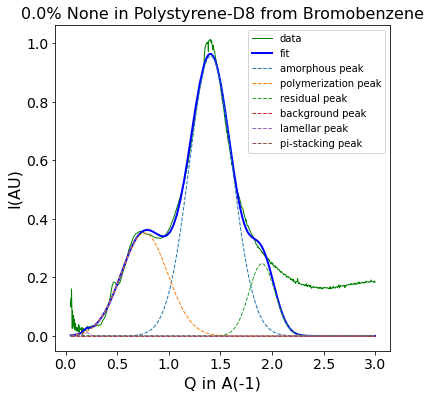

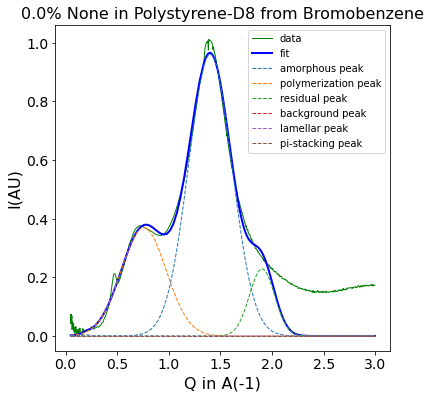

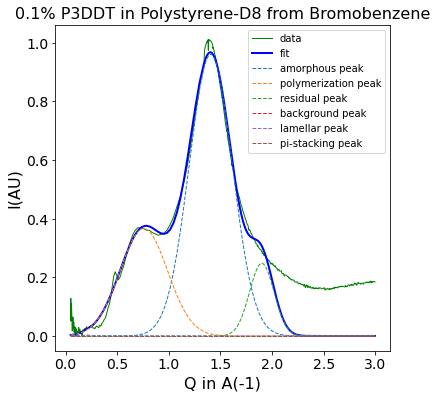

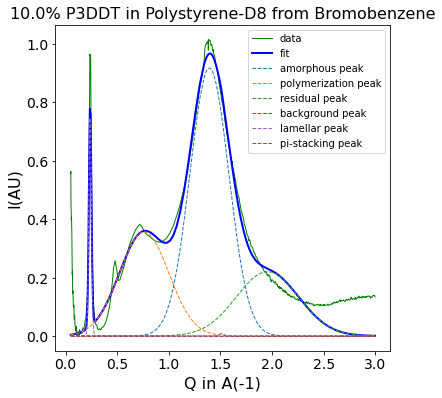

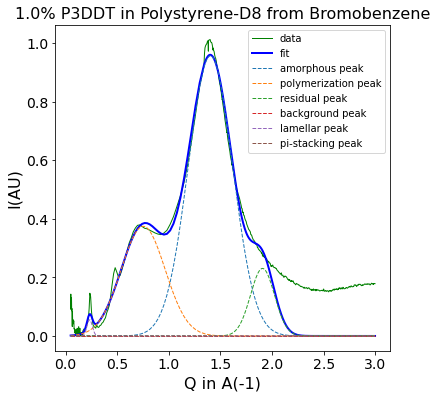

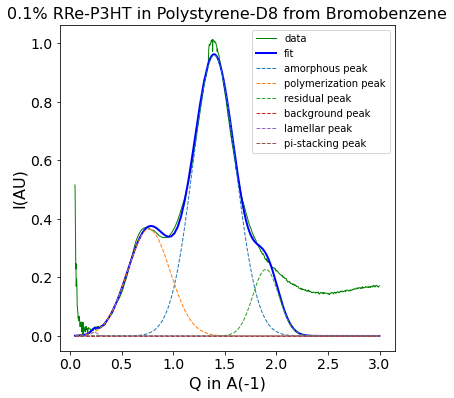

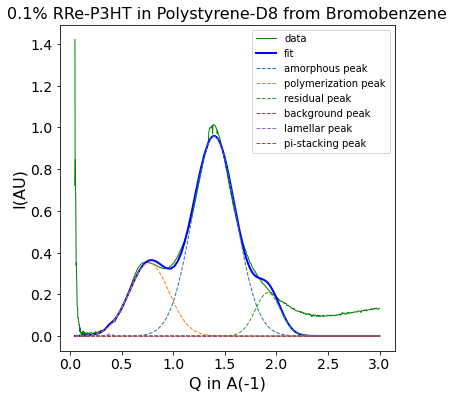

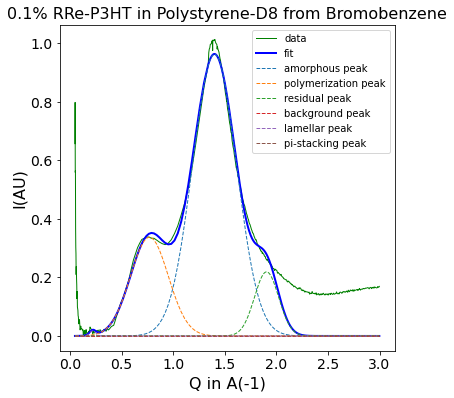

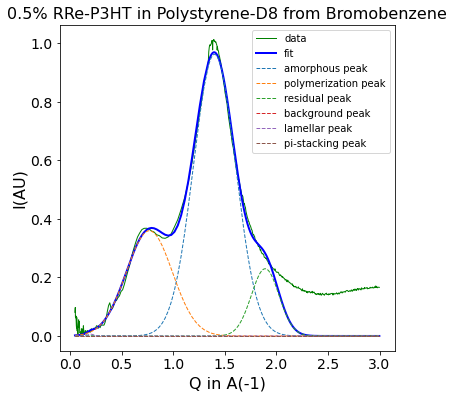

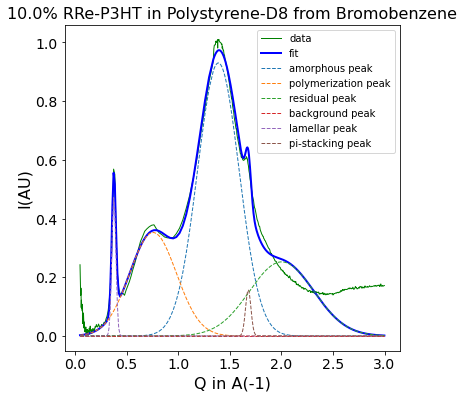

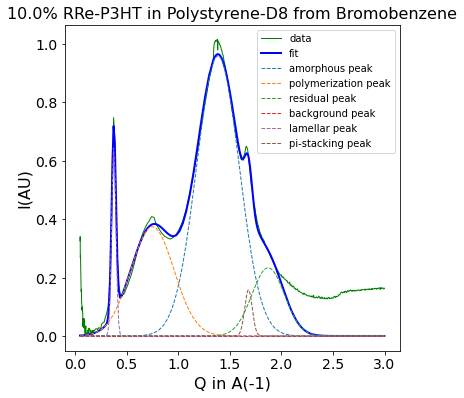

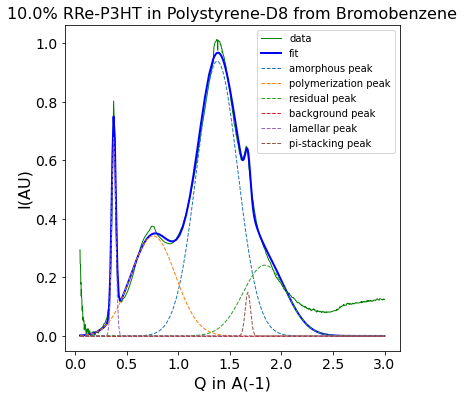

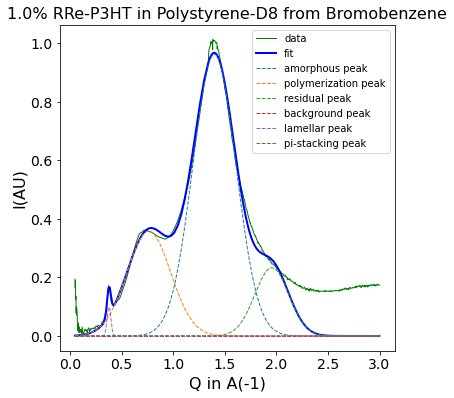

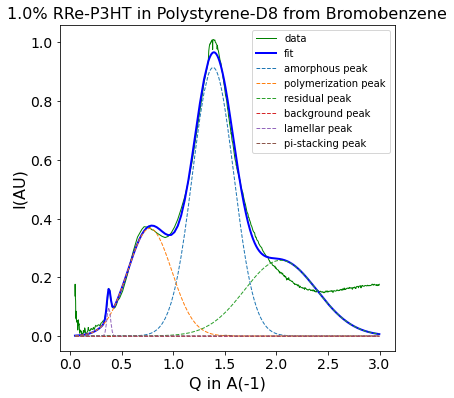

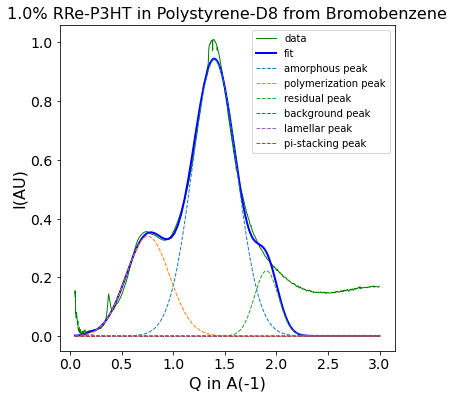

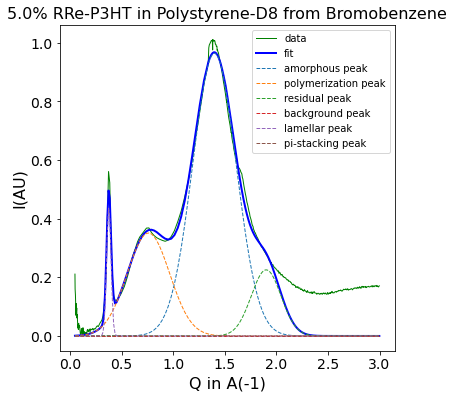

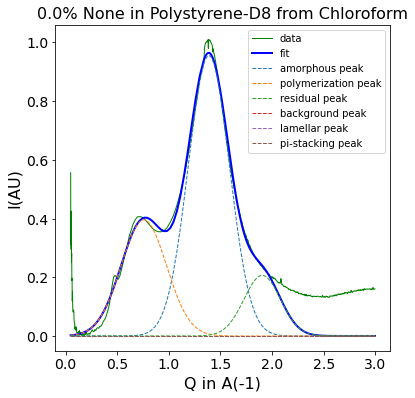

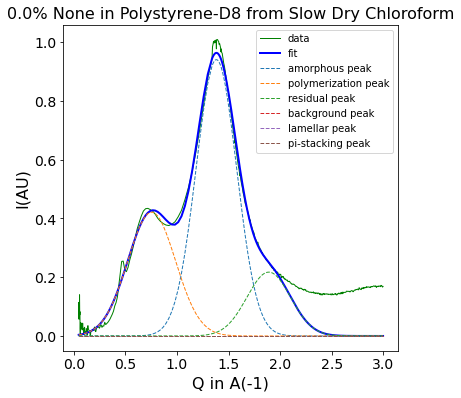

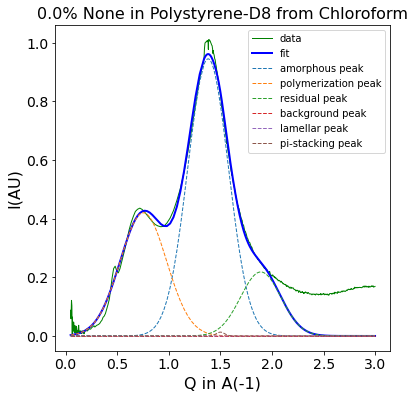

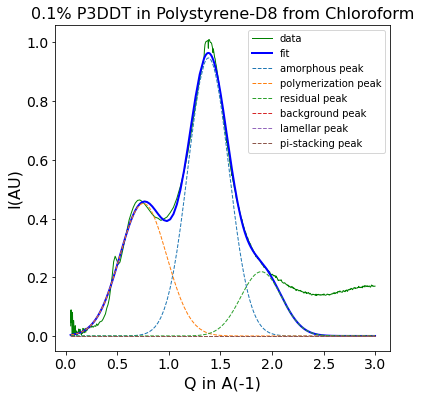

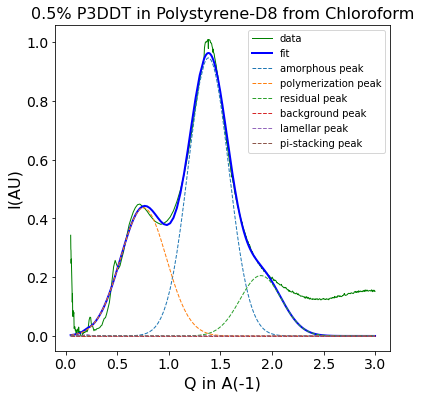

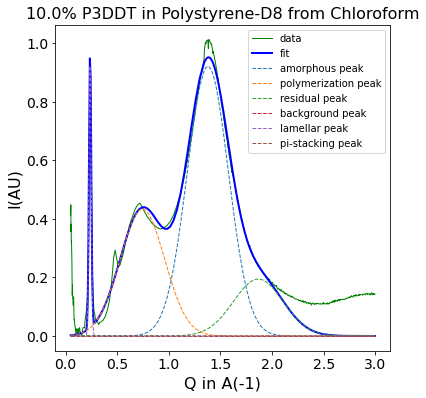

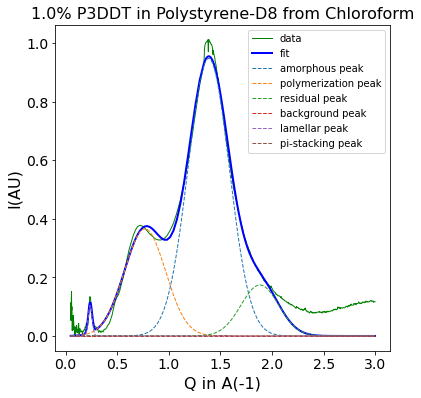

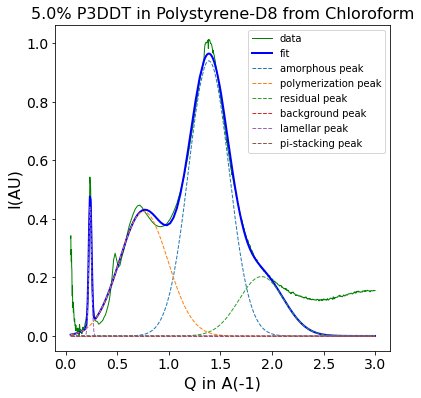

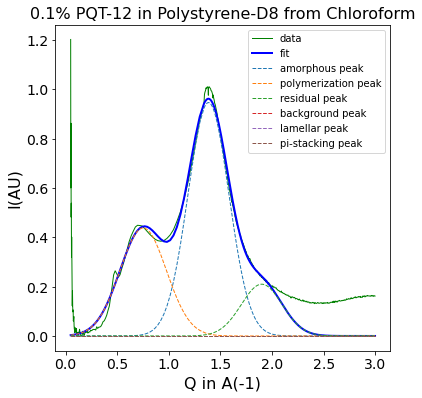

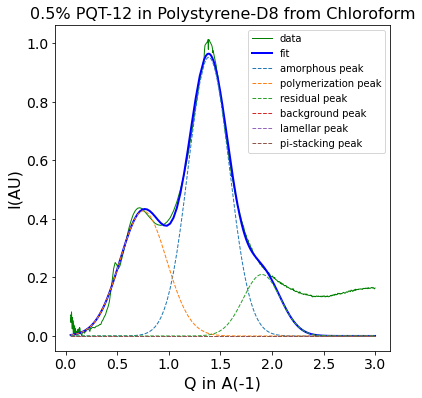

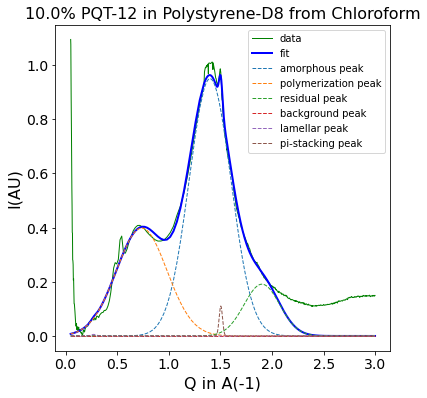

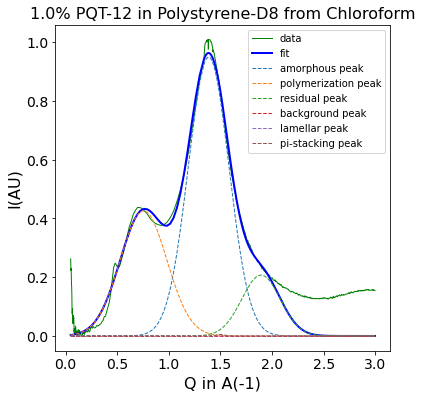

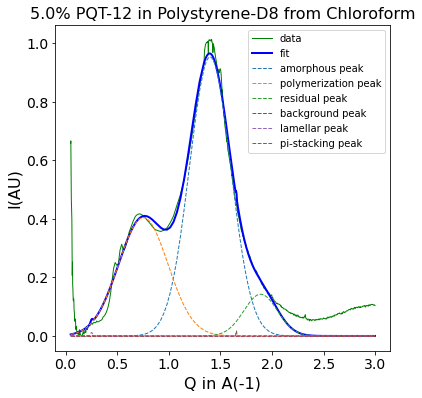

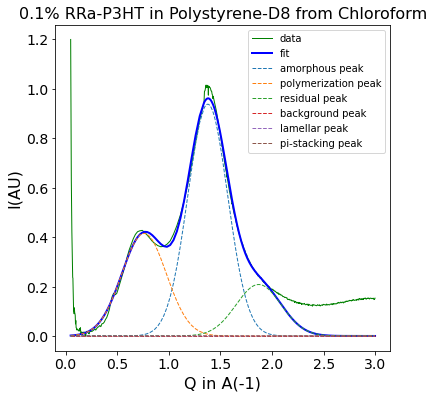

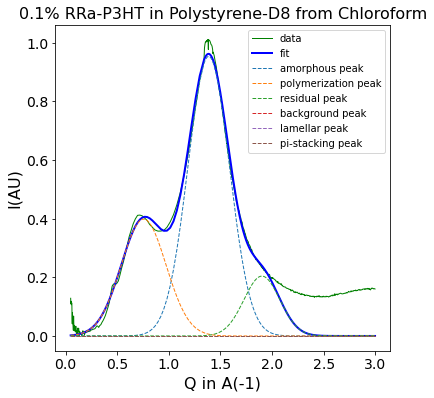

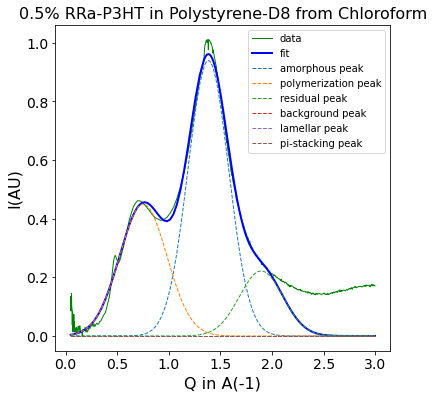

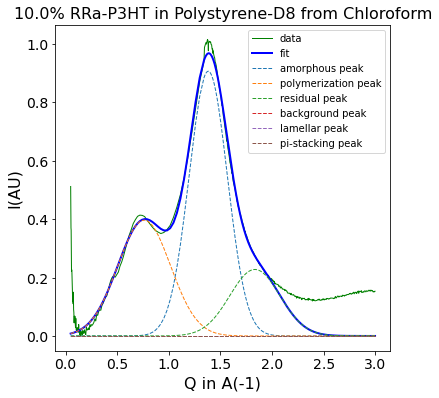

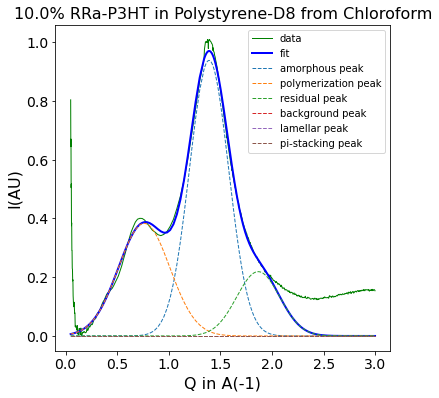

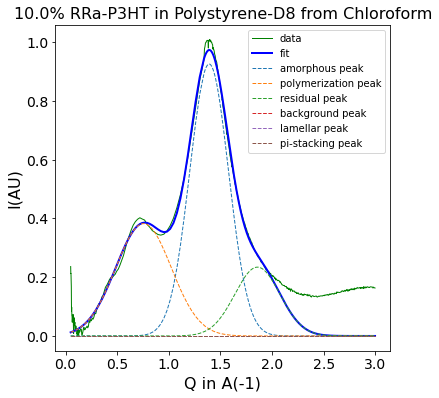

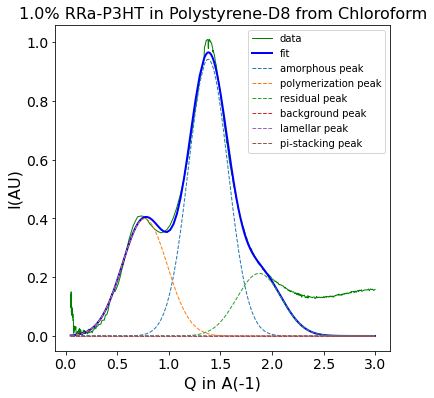

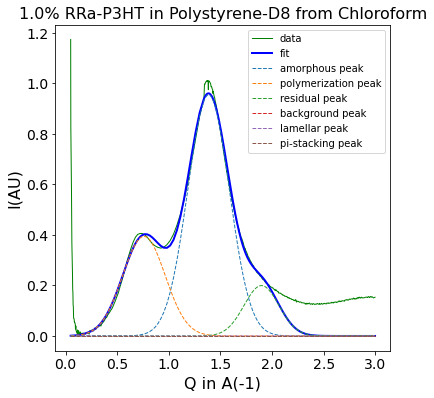

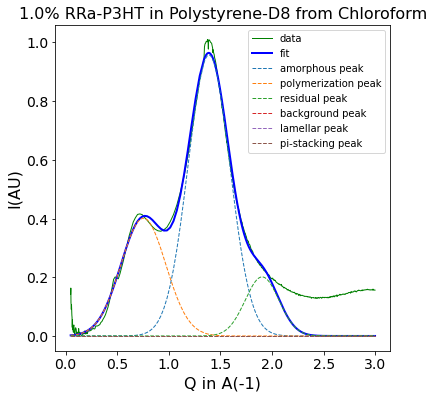

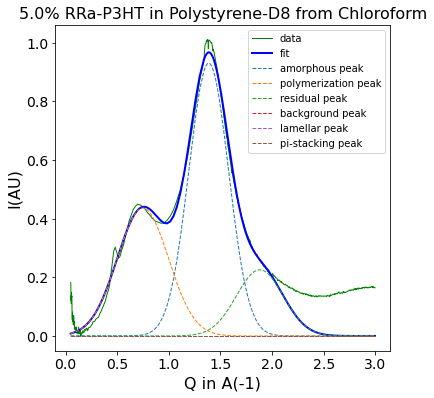

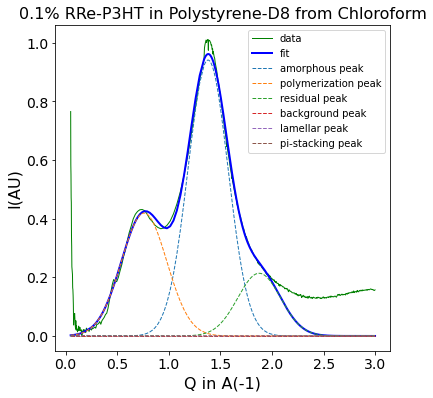

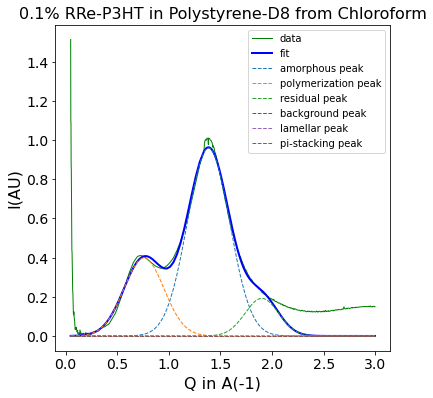

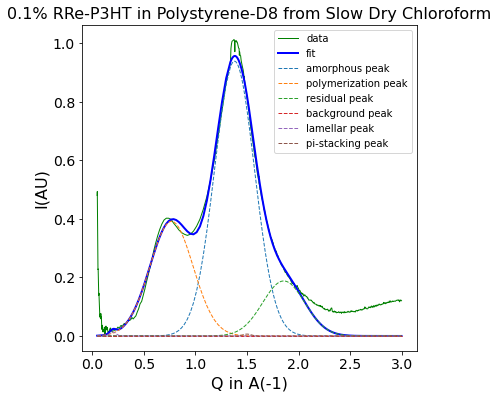

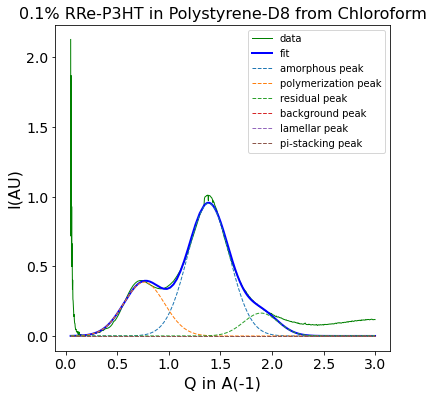

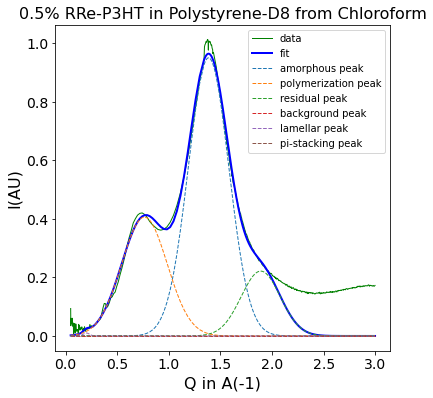

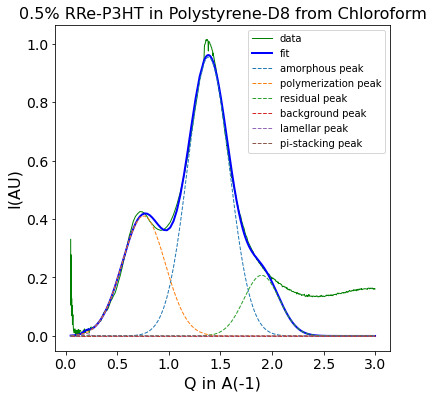

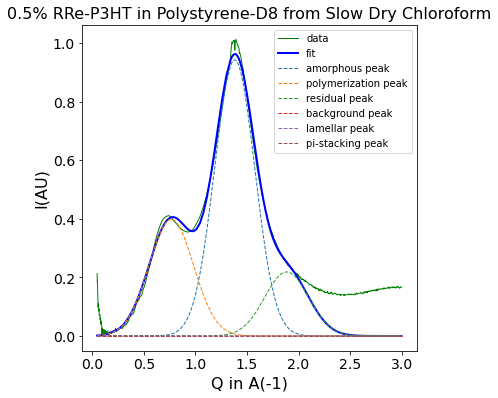

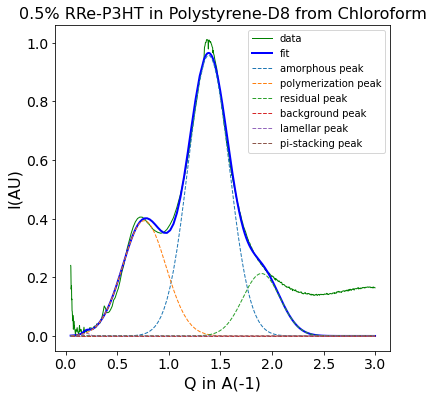

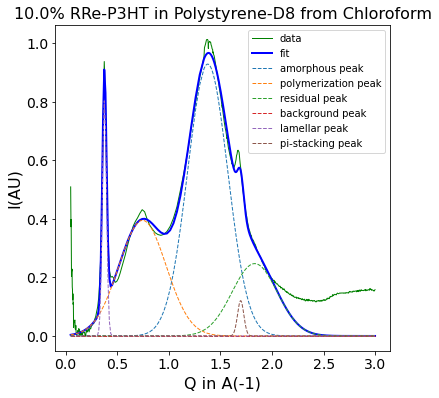

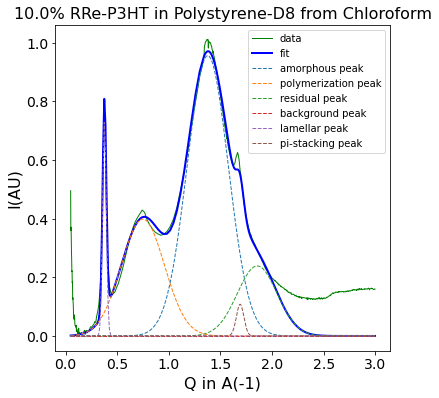

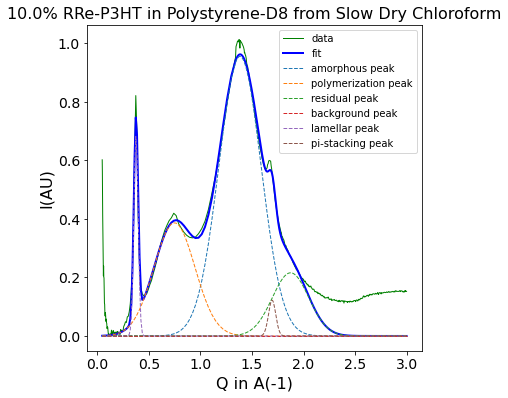

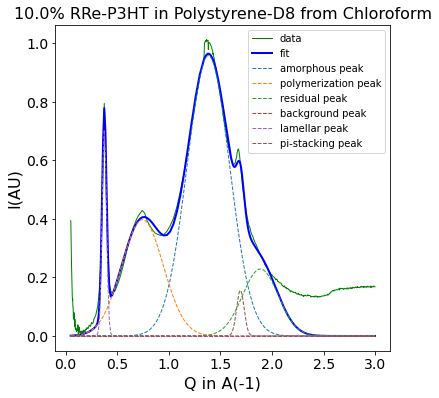

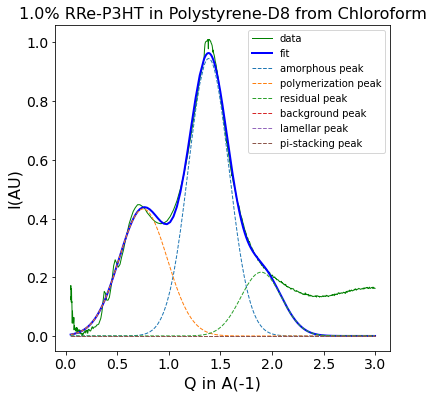

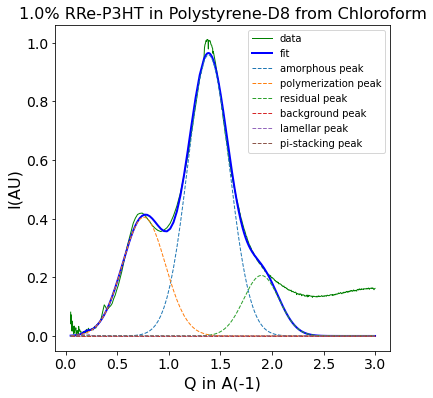

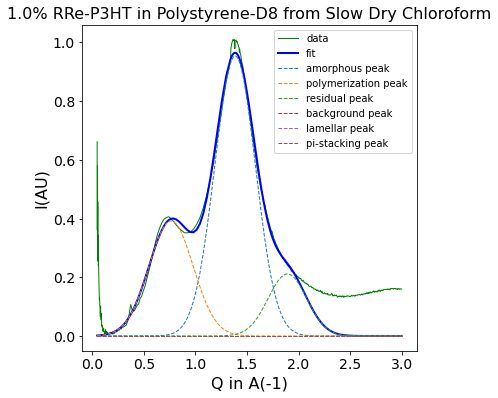

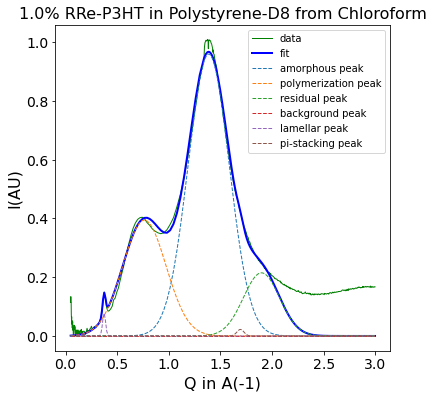

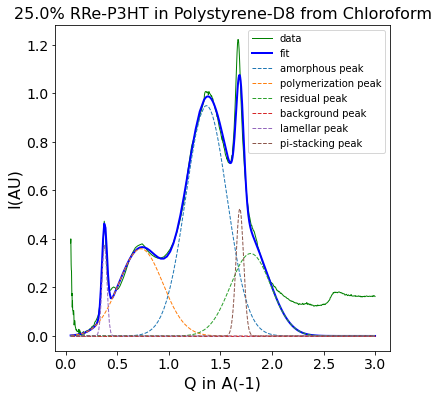

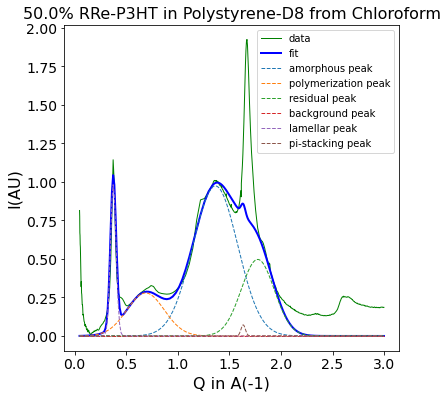

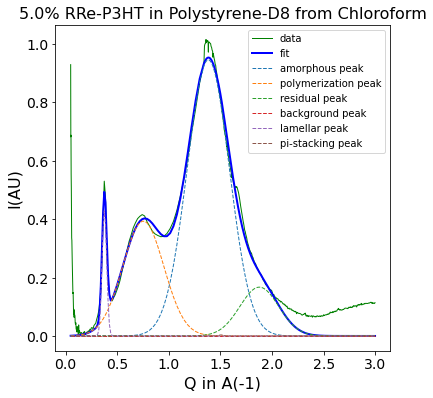

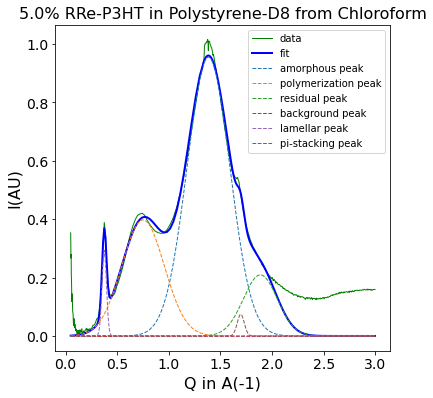

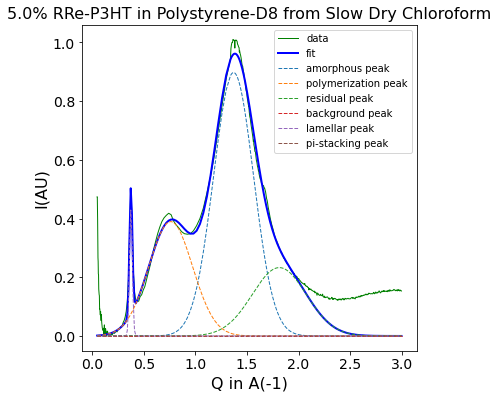

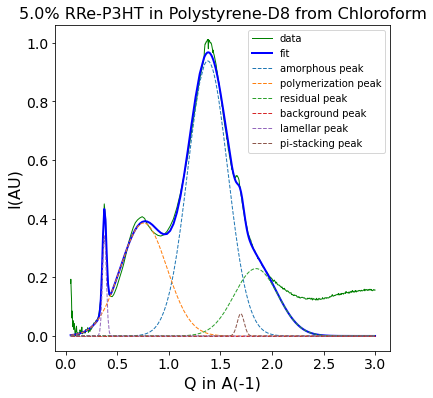

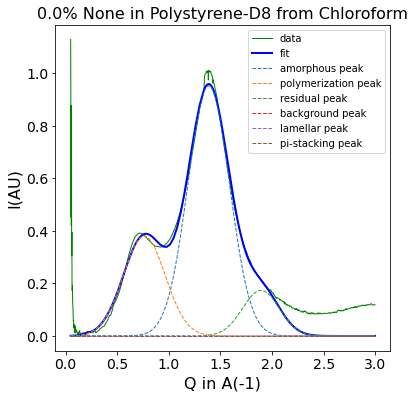

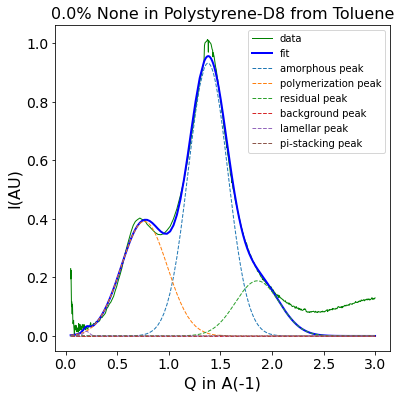

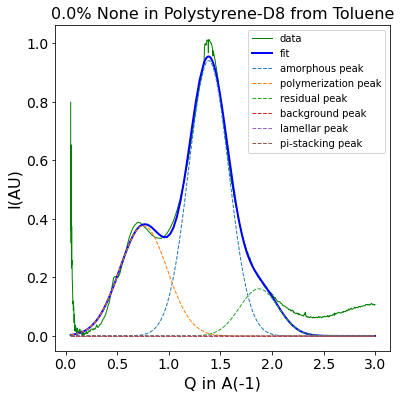

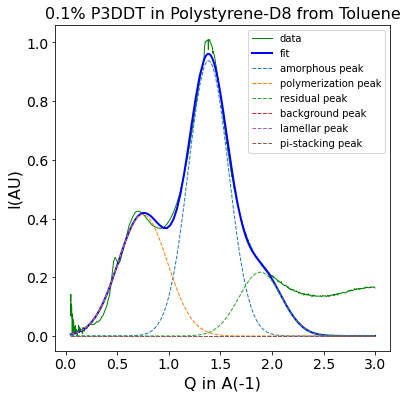

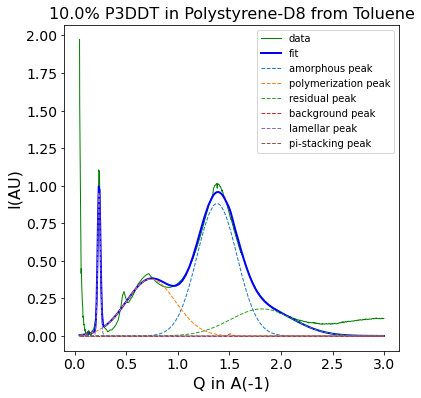

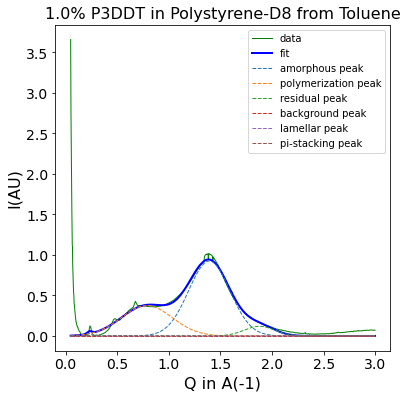

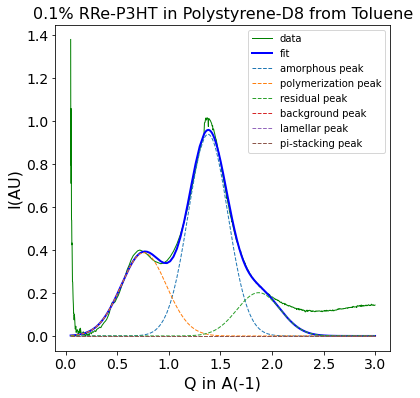

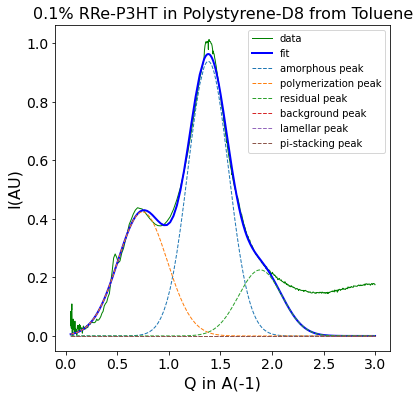

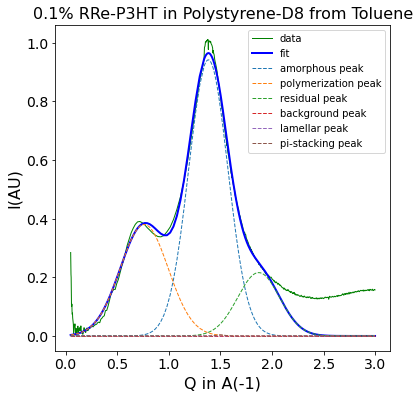

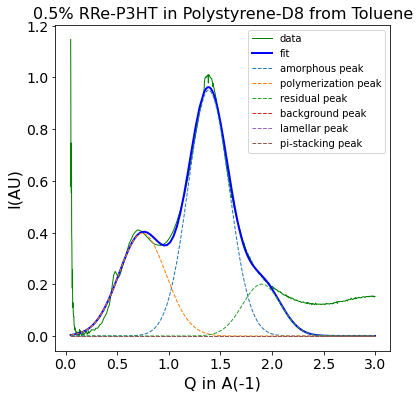

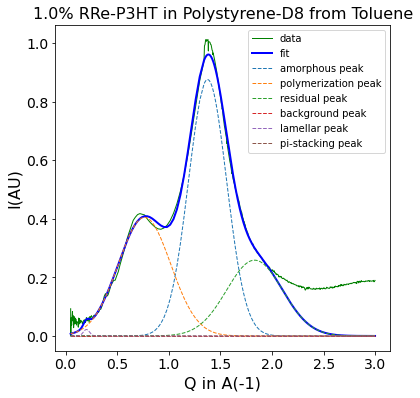

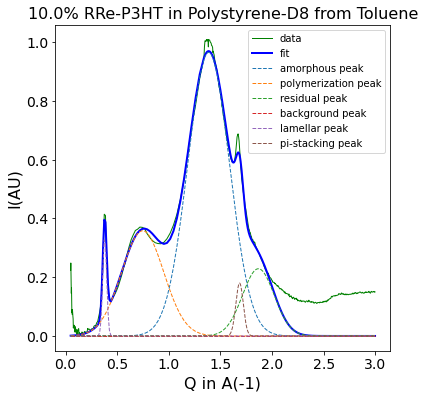

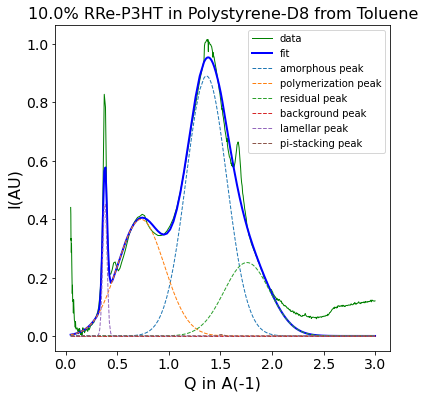

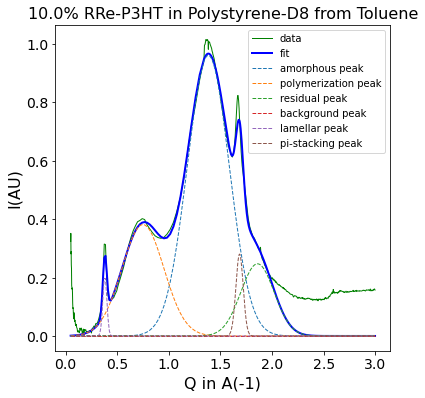

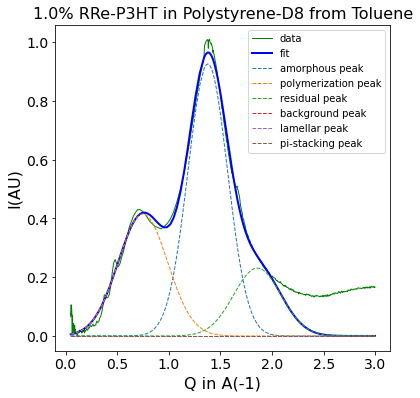

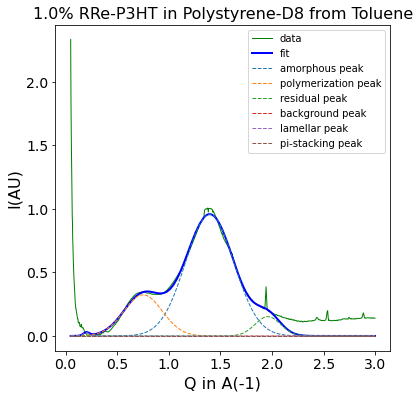

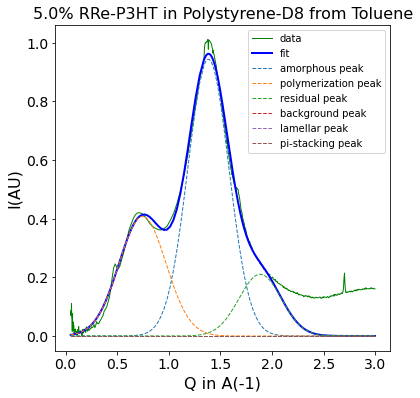

In [41]:
# you can see the fits here and refit with new initial parameters those that did not fit well. 
for num in waxs_data:
    fit_plotter([num],fit_reader(num))

# Section 3: Fitting  Analysis

In [14]:
# returns a dictionary with the crystal sizes based on scherrer analysis given a key whose sample is fit

def crystal_size(key):
    # the FWHM and the bragg angle must be in radians. We currently have it in A(-1)
    theta = np.arcsin(fit_reader(key)['E_peak_pos']/2)
    sigma = np.arcsin(fit_reader(key)['E_sigma']/2)
    beta = 2.3548 * sigma
    lamellar_size = 0.9/(beta * math.cos(theta))
    if lamellar_size < 5:
        lamellar_size = 'not present'

    pi_size = {}
    # the FWHM and the bragg angle must be in radians. We currently have it in A(-1)
    theta = np.arcsin(fit_reader(key)['F_peak_pos']/2)
    sigma = np.arcsin(fit_reader(key)['F_sigma']/2)
    beta = 2.3548 * sigma
    pi_size = 0.9/(beta * math.cos(theta))
    if pi_size <5:
        pi_size = 'not present'
        
    return lamellar_size, pi_size

def peak_height(key):
    lamellar_peak_height = fit_reader(key)['E_scale']     
    pi_peak_height = fit_reader(key)['F_scale']
        
    return lamellar_peak_height, pi_peak_height

In [15]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'darkorchid'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'darkorchid',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]

solubility = {}
solubility['Bromobenzene'] = 84.1
solubility['Chloroform'] = 14.1
solubility['Toluene'] = 0.7
solubility['Slow Dry Chloroform'] = 14.1

polarity = {}
polarity['Bromobenzene'] = 5.17
polarity['Chloroform'] = 4.81
polarity['Toluene'] = 2.38
polarity['Slow Dry Chloroform'] = 4.81

figure_path = data_path +'_figures'
if 'desmeared_waxs_data_figures' in os.listdir(path):
    print('figures path already exists')
else:
    os.mkdir(figure_path)

figures path already exists


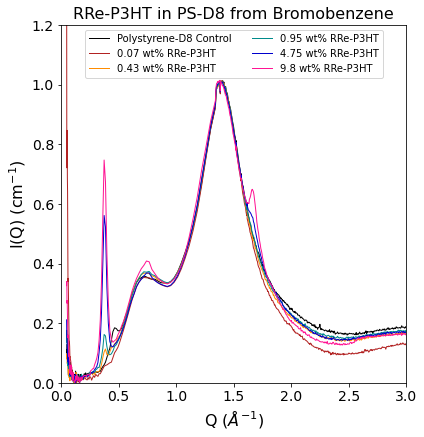

In [139]:
samplelist = [310,301,302,303,304,305]
name_of_figure = 'RRe P3HT in BB all wt percent without fits'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= wt_names[sample], c = wt_colors[sample])
    
plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

legend_title = None
legend = plt.legend(fontsize=10, title=legend_title, loc='upper center',ncol=2)
legend.get_title().set_fontsize('10')


plt.ylim(0, 1.2)
plt.xlim(0, 3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()


repsample = samplelist[0]
plt.title(cps[repsample] + ' in PS-D8 from ' +solvent_names[repsample], fontsize =16)

plt.savefig(filename, dpi=600, bbox_inches='tight')

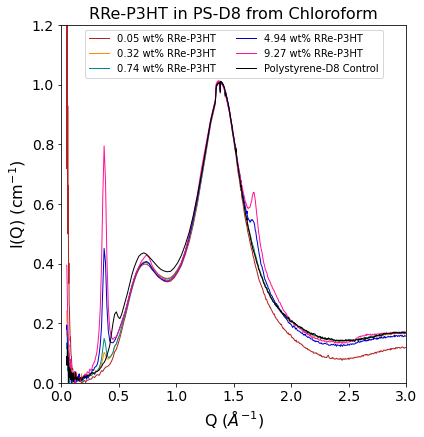

In [140]:
samplelist = [108,109,110,111,112,114]
name_of_figure = 'RRe P3HT in CF all wt percent without fits'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= wt_names[sample], c = wt_colors[sample])
    
plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

legend_title = None
legend = plt.legend(fontsize=10, title=legend_title, loc='upper center',ncol=2)
legend.get_title().set_fontsize('10')

plt.ylim(0, 1.2)
plt.xlim(0, 3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

repsample = samplelist[0]
plt.title(cps[repsample] + ' in PS-D8 from ' +solvent_names[repsample], fontsize =16)

plt.savefig(filename, dpi=600, bbox_inches='tight')

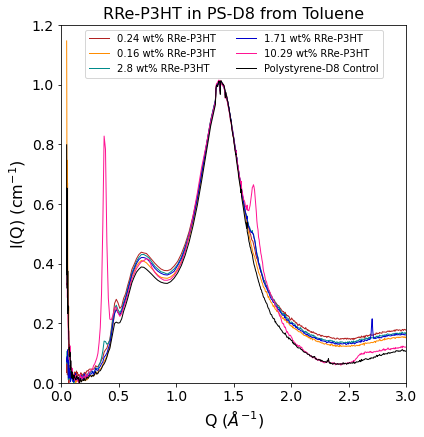

In [141]:
samplelist = [401,402,403,404,405, 409]
name_of_figure = 'RRe P3HT in Tol all wt percent without fits'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= wt_names[sample], c = wt_colors[sample])
    
plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

legend_title = None
legend = plt.legend(fontsize=10, title=legend_title, loc='upper center',ncol=2)
legend.get_title().set_fontsize('10')

plt.ylim(0, 1.2)
plt.xlim(0, 3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

repsample = samplelist[0]
plt.title(cps[repsample] + ' in PS-D8 from ' +solvent_names[repsample], fontsize =16)

plt.savefig(filename, dpi=600, bbox_inches='tight')

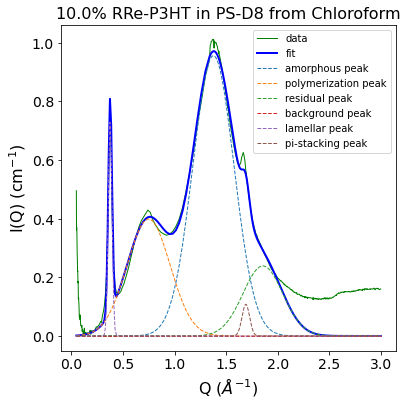

In [90]:
#example of a gaussian fit
name_of_figure = 'example of a gaussian fit 10% rre in psd8 from CF'
filename = figure_path + '/' + name_of_figure
fit_plotter([105],fit_reader(105))
plt.savefig(filename, dpi=600)

Plot of the peak ratios for all RRe-P3HT/PS-D8 samples from all solvents no matter if they are plotted in the other plots of this figure or in the supplemental. The height ratio will be a function of the actual wt% of the samples.

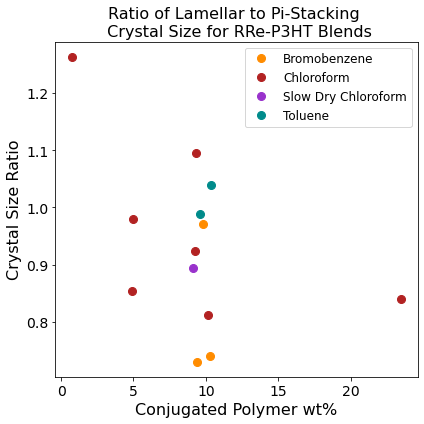

In [142]:
samplelist = []
for num in waxs_data:
    if cps[num] == 'RRe-P3HT':
        samplelist.append(num)
samplelist.remove(107)        
        
name_of_figure = 'crystal ratios all RRe'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
label_counter = []
for sample in samplelist:
    lamel, pi = crystal_size(sample)
    l,p = peak_height(sample)
    if l < 0.01 or p < 0.01:
        a = 1
    else:
        x = actual[sample]
        y = lamel/pi
        if solvent_names[sample] in label_counter:
            plt.errorbar(x, y,fmt='o', c = solvent_colors[sample], ms=8)
        else:
            plt.errorbar(x, y,fmt='o', label= solvent_names[sample], c = solvent_colors[sample], ms=8)
            label_counter.append(solvent_names[sample])


plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.ylabel('Crystal Size Ratio', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Ratio of Lamellar to Pi-Stacking \n Crystal Size for RRe-P3HT Blends',fontsize=16)

plt.legend(fontsize=12,loc='upper right',title=None, title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')

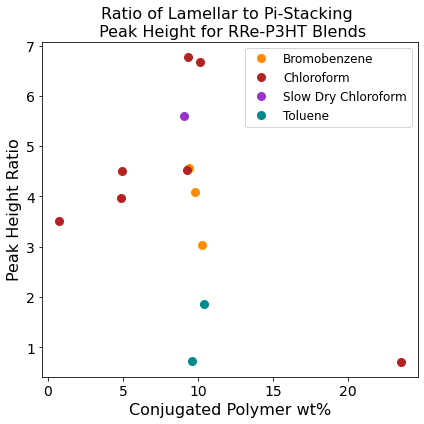

In [135]:
samplelist = []
for num in waxs_data:
    if cps[num] == 'RRe-P3HT':
        samplelist.append(num)
samplelist.remove(107)        
        
name_of_figure = 'peak height ratios all RRe'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
label_counter = []
for sample in samplelist:
    lamel, pi = peak_height(sample)
    if lamel < 0.01 or pi < 0.01:
        a = 1
    else:
        x = actual[sample]
        y = lamel/pi
        if solvent_names[sample] in label_counter:
            plt.errorbar(x, y,fmt='o', c = solvent_colors[sample], ms=8)
        else:
            plt.errorbar(x, y,fmt='o', label= solvent_names[sample], c = solvent_colors[sample], ms=8)
            label_counter.append(solvent_names[sample])


plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.ylabel('Peak Height Ratio', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Ratio of Lamellar to Pi-Stacking \n Peak Height for RRe-P3HT Blends',fontsize=16)

plt.legend(fontsize=12,loc='upper right',title=None, title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig(filename, dpi=300)

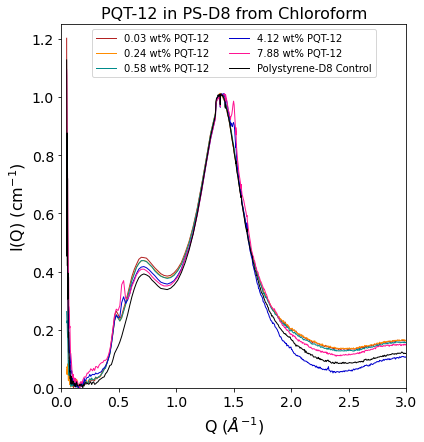

In [46]:
samplelist = [16,17,18,19,20,21]
name_of_figure = 'PQT12 in CF'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= wt_names[sample], c = wt_colors[sample])
    
plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

legend_title = None
legend = plt.legend(fontsize=10, title=legend_title, loc='upper center',ncol=2)
legend.get_title().set_fontsize('10')


plt.ylim(0, 1.25)
plt.xlim(0, 3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()


repsample = samplelist[0]
plt.title(cps[repsample] + ' in PS-D8 from ' +solvent_names[repsample], fontsize =16)

plt.savefig(filename, dpi=600, bbox_inches='tight')